In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn.datasets as datasets
from tqdm import tqdm
import torch
device = torch.device('cuda')
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as utils
import uproot
import matplotlib.colors as colors
import awkward as ak
import imageio   

## Change the line below this to point to the directory where you have cloned the nflows package

sys.path.append("/home/sambt/CASE_final/CASE_QUAK_final/")
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

#Rational Quadratic Splines Normalizing Flow

In [2]:
#--PLOTTING PARAMETERS AND plot_quak function--
#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

def plot_quak(loss1, loss2, title='Quak Space',xlim=[-10,10],ylim=[-10,10],nbins=100, xlabel = 'x', ylabel = 'y',lower_mass = None, upper_mass = None, images = None):
    
    loss1_bins = np.linspace(xlim[0],xlim[1],nbins)
    loss2_bins = np.linspace(ylim[0],ylim[1],nbins)
    
    hist2, _, _ = np.histogram2d(list(loss1), list(loss2), bins=(loss1_bins, loss2_bins))
    L1, L2 = np.meshgrid(loss1_bins, loss2_bins)
    fig,axes = plt.subplots(1,1,figsize=(12,5))
    #plt.sca(axes[0])
    
    pc = axes.pcolormesh(L1, L2, hist2.T, cmap="Reds") #norm=colors.LogNorm()
    plt.colorbar(pc)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.canvas.draw()       
    #axes.zaxis.set_scale('log')
    #plt.scatter(loss1,loss2)
    if images != None:
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

#plot_quak(train_loss1,train_loss2)

In [3]:
bkgCut = -1.
jmevar = 0
def prepare_data(file_name,lower_mass_cut = 1500, upper_mass_cut = 6000):
    file1 = uproot.open(file_name) #--get data from branches --
    tree1 = file1['output']
        
    branches = tree1.arrays()
        
    #mass = branches['mass']
    mass = branches['mjj']
    loss1 = branches['loss2'] #sig_loss
    loss2 = branches['loss1'] #bkg_loss
    label = branches['label']
    if('samp_label' in branches): #--check if sample label is present--
        samp_label = branches['samp_label']
    else:
        samp_label = np.zeros(len(branches['label']))
    if('mj1' in branches):
        mj1 = branches['mj1']
        mj2 = branches['mj2']
    else:
        mj1 = np.zeros(len(branches['label']))
        mj2 = np.zeros(len(branches['label']))
    if('evt_idx' in branches):
        evt_idx = branches['evt_idx']
    else:
        evt_idx = np.zeros(len(branches['label']))
        JME_flag = branches['JME_flag']
    '''
    mass = mass[loss2>bkgCut]
    loss1 = loss1[loss2>bkgCut]
    label = label[loss2>bkgCut]
    samp_label = samp_label[loss2>bkgCut]
    mj1 = mj1[loss2>bkgCut]
    mj2 = mj2[loss2>bkgCut]
    evt_idx = evt_idx[loss2>bkgCut]
    JME_flag = JME_flag[loss2>bkgCut]
    loss2 = loss2[loss2>bkgCut]
    '''
    jmeselection = np.logical_or(JME_flag==-1, JME_flag==jmevar)
    mass = mass[jmeselection]
    loss1 = loss1[jmeselection]
    loss2 = loss2[jmeselection]
    label = label[jmeselection]
    samp_label = samp_label[jmeselection]
    mj1 = mj1[jmeselection]
    mj2 = mj2[jmeselection]
    evt_idx = evt_idx[jmeselection]
    JME_flag = JME_flag[jmeselection]   
    
    #Apply Minimum Mass cut
    mass_cut = np.logical_and(mass>lower_mass_cut,mass<upper_mass_cut)
    loss1 = loss1[mass_cut]
    loss2 = loss2[mass_cut]
    label = label[mass_cut]
    samp_label = samp_label[mass_cut]
    mj1 = mj1[mass_cut]
    mj2 = mj2[mass_cut]
    evt_idx = evt_idx[mass_cut]
    JME_flag = JME_flag[mass_cut] 
    mass = mass[mass_cut]
    
    return mass,loss1,loss2,label,samp_label,mj1,mj2,evt_idx,JME_flag



In [4]:
def make_flow(num_features,num_context,kwargs,perm=True):
    base_dist = StandardNormal(shape=[num_features])
    transforms = []
    if num_context == 0:
        num_context = None
    for i in range(kwargs['num_layers']): #create the layer
        transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=num_features,
                                                                                 context_features = num_context,
                                                                                 hidden_features = kwargs['hidden_features'],
                                                                                 num_bins = kwargs['num_bins'],
                                                                                 num_blocks = kwargs['num_blocks_per_layer'],
                                                                                 tail_bound = kwargs['tail_bound'],
                                                                                 tails = kwargs['tails'],
                                                                                 dropout_probability=kwargs['dropout'] if 'dropout' in kwargs.keys() else 0,
                                                                                 use_batch_norm=kwargs['batchnorm'] if 'batchnorm' in kwargs.keys() else False))
        if i < kwargs['num_layers'] - 1 and perm: #if not the last layer, add permutation
            transforms.append(ReversePermutation(features=num_features))
    transform = CompositeTransform(transforms) #create transform from layers
    flow = Flow(transform,base_dist) #create normalizing flow given the layer structure and the base dist(num_features).
    return flow

class InfiniteLoader(utils.DataLoader):
    """A data loader that can load a dataset repeatedly."""

    def __init__(self, num_epochs=None, *args, **kwargs):
        """Constructor.

        Args:
            dataset: A `Dataset` object to be loaded.
            batch_size: int, the size of each batch.
            shuffle: bool, whether to shuffle the dataset after each epoch.
            drop_last: bool, whether to drop last batch if its size is less than
                `batch_size`.
            num_epochs: int or None, number of epochs to iterate over the dataset.
                If None, defaults to infinity.
        """
        super().__init__(
            *args, **kwargs
        )
        self.finite_iterable = super().__iter__()
        self.counter = 0
        self.num_epochs = float('inf') if num_epochs is None else num_epochs

    def __next__(self):
        try:
            return next(self.finite_iterable)
        except StopIteration:
            self.counter += 1
            if self.counter >= self.num_epochs:
                raise StopIteration
            self.finite_iterable = super().__iter__()
            return next(self.finite_iterable)

    def __iter__(self):
        return self

    def __len__(self):
        return None
                      
    
def trainFlow(flow,data,context=None,n_epoch=20,lr=0.001,wd=0.0,bs=256,patience=-1,n_avg=100,anneal=True):
    flow = flow.to(device)
    if wd>0:
        optimizer = optim.AdamW(flow.parameters(),lr=lr,weight_decay=wd)
    else:
        optimizer = optim.AdamW(flow.parameters(),lr=lr)
        
    n_iter = n_epoch*data.shape[0]//bs #bs is batch size
    if anneal:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=n_iter,eta_min=lr,verbose=False)
    
    if context is None: # only used if you are training a conditional normalizing flow, in which case the context input is the conditioning variables
        dataset = utils.TensorDataset(torch.tensor(data,dtype=torch.float32,device=device))
    else:
        dataset = utils.TensorDataset(torch.tensor(data,dtype=torch.float32,device=device),torch.tensor(context,dtype=torch.float32,device=device))
    loader = InfiniteLoader(dataset=dataset,batch_size=bs,shuffle=True,generator=torch.Generator(device=device))

    min_loss = 1e+8
    train_losses = [] #loss history
    patience_count = 0
    bestState = None
    
    print("Training Flow")
    
    tbar = tqdm(range(n_iter))
    avg_losses = []
    for i in tbar:
        if patience_count == patience: #check for patience
            break
        optimizer.zero_grad() #set zero-gradient
        if context is None: #check for context
            x, = next(loader)
            loss = -flow.log_prob(inputs=x)[0].mean() #define loss given context
        else:
            x,y = next(loader)
            loss = -flow.log_prob(inputs=x,context=y)[0].mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            bestState = flow.state_dict()
            patience_count=0
        else:
            patience_count +=1
        avg_losses.append(loss.item())
        if i+1 > n_avg:
            avg_losses = avg_losses[1:]
        l_print = np.mean(avg_losses)
        s = 'Loss: {0}, p = {1}'.format(l_print,patience_count)
        tbar.set_description(s)
        if anneal:
            scheduler.step()
        if i % 1000 == 0:
            torch.save(flow.load_state_dict(bestState),"/home/derickfm/nf-tutorial/RQSNF")
    
    flow.load_state_dict(bestState)
    flow.eval()
    del dataset, loader, optimizer
    torch.cuda.empty_cache()
    flow = flow.to('cpu')
    
    plt.figure(figsize=(8,6))
    w = int(data.shape[0]/(5*bs))
    smooth = np.convolve(np.ones(w),train_losses,mode='valid')/w
    xvals = np.linspace(0,len(train_losses),len(smooth))
    plt.plot(xvals,smooth)


    return flow

/home/derickfm/.conda/envs/quak/lib/python3.7/site-packages/awkward/highlevel.py:1504: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if element in test:


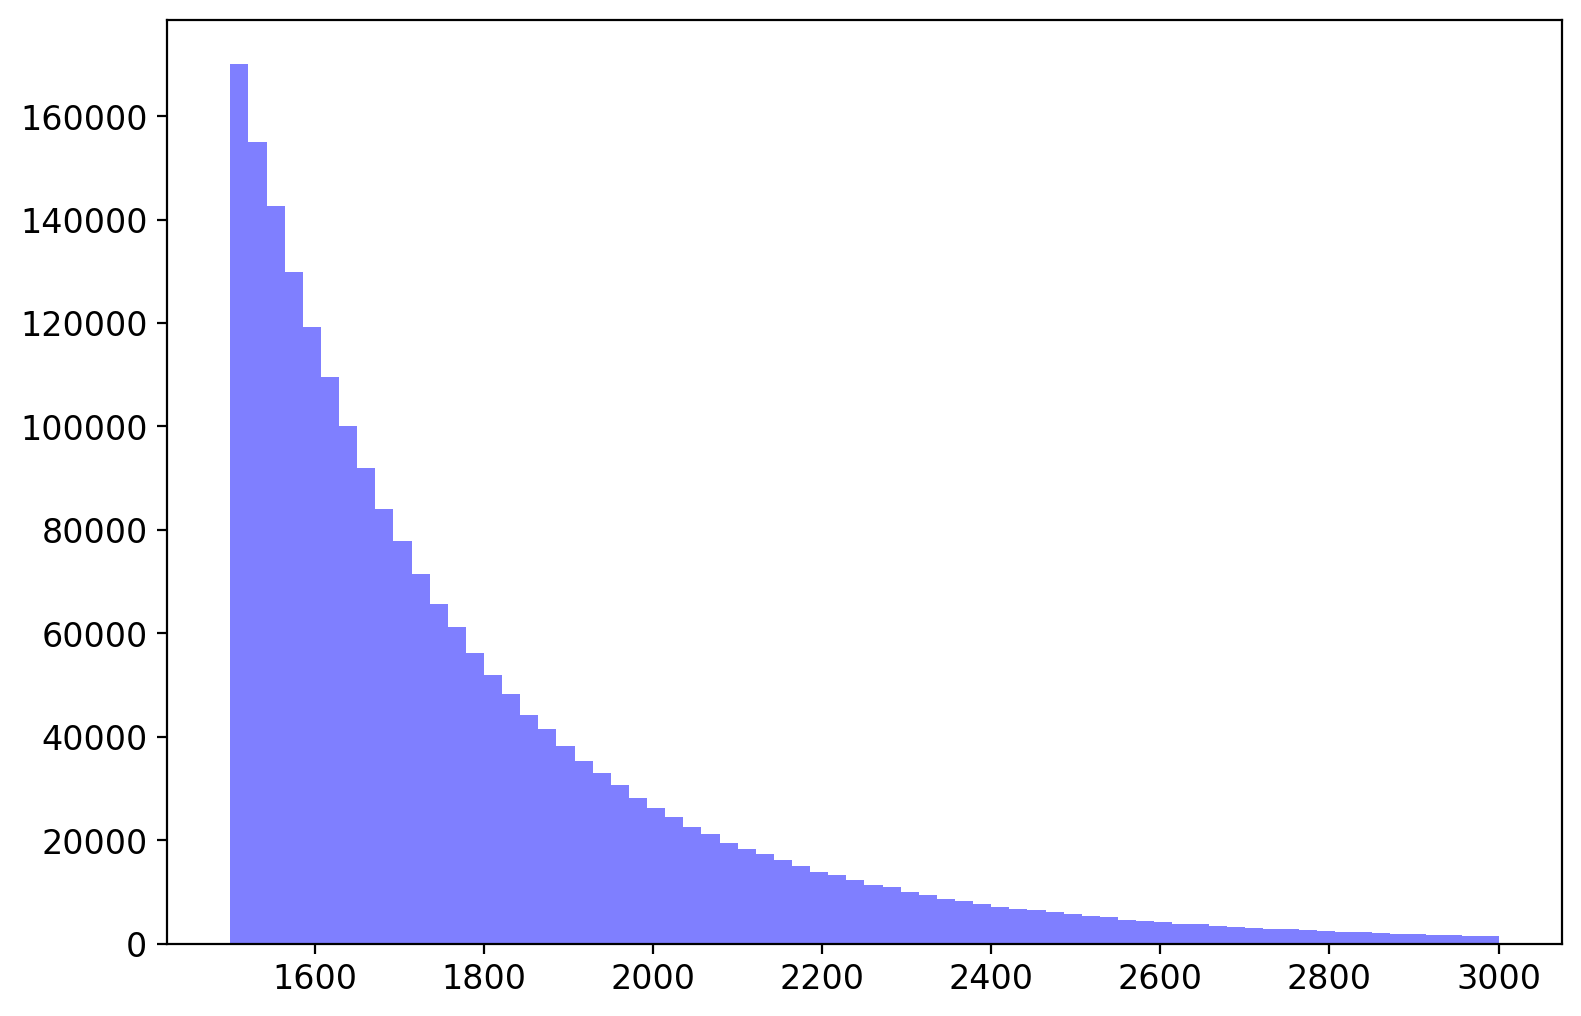

(100353,) (127743,)


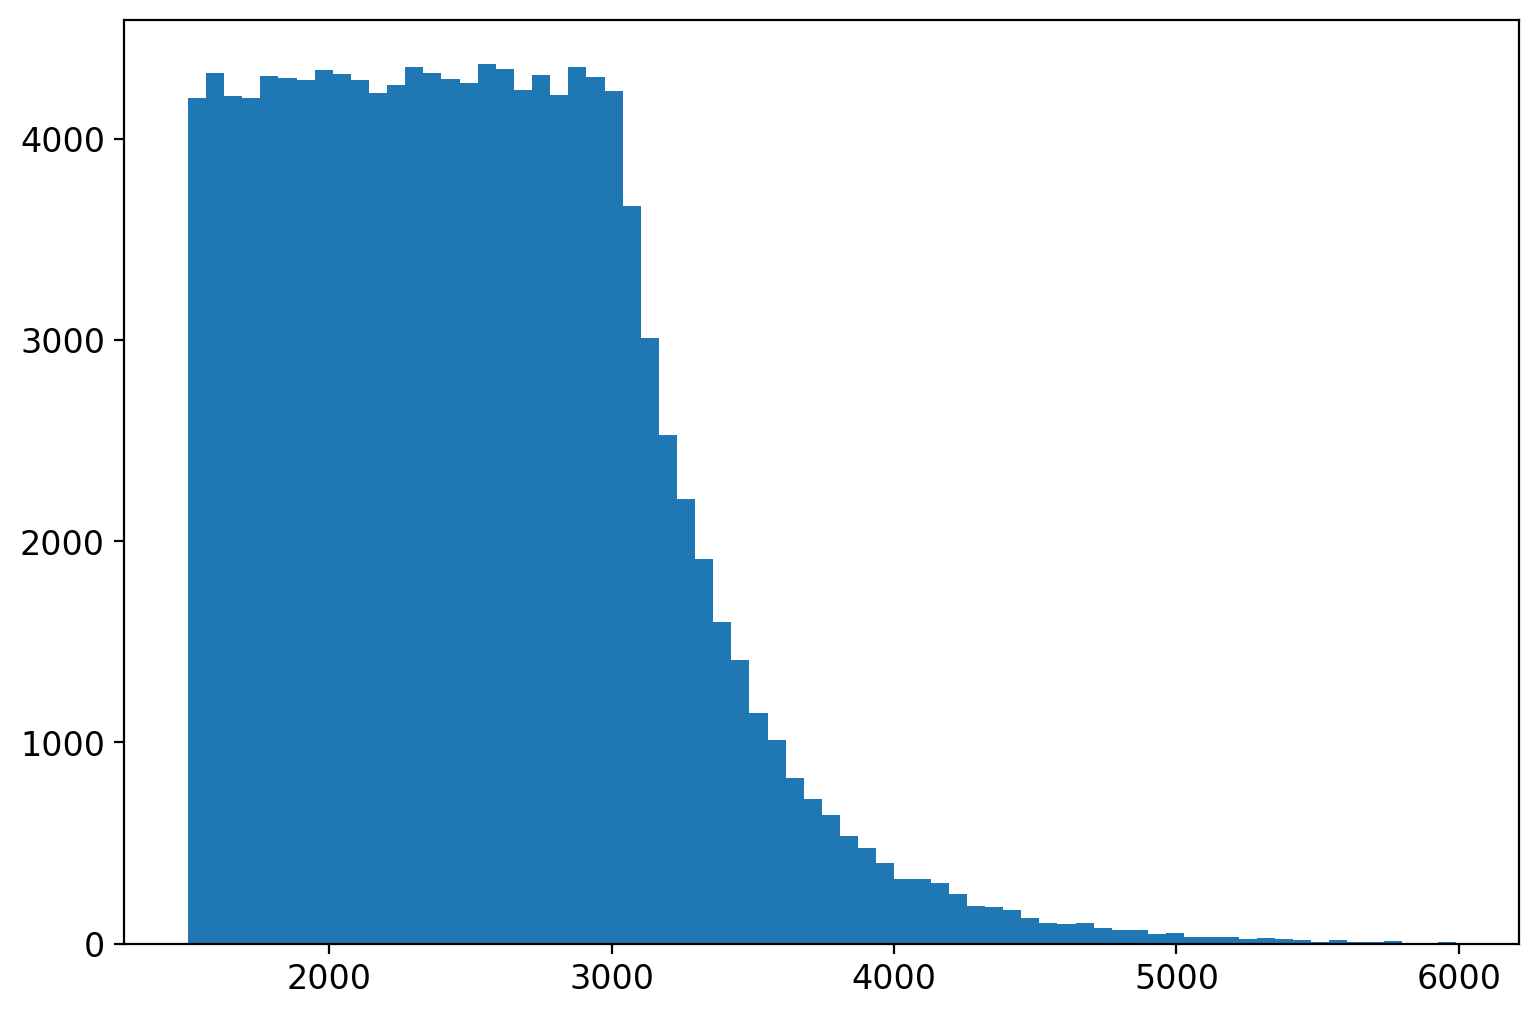

In [18]:
#get train and val data
lower_mass_bound = 1500
upper_mass_bound = 3000
train_mass,train_loss1,train_loss2,train_label,train_samp_label,train_mj1,train_mj2,train_evt_idx,train_JME_flag = prepare_data('/nobackup/users/derickfm/inject480XYY3000Events_withNNScore.root',lower_mass_cut = lower_mass_bound)
val_mass,val_loss1,val_loss2,val_label,val_samp_label,val_mj1,val_mj2,val_evt_idx,val_JME_flag = prepare_data('/nobackup/users/derickfm/inject240XYY3000Events_withNNScore.root',lower_mass_cut = lower_mass_bound)
#print(val_mass,np.array(val_mass))

#get train mass copy for later functions
train_mass_tmp = train_mass[:]
train_loss1_tmp = train_loss1[:]
train_loss2_tmp = train_loss2[:]
'''
#set up val loss array
val_loss1 = np.array(val_loss1)
val_data = (val_loss1-val_loss1.mean())/val_loss1.std()
val_loss2 = np.array(val_loss2)
val_data = (val_loss2-val_loss2.mean())/val_loss2.std()
val_data = np.vstack((val_loss1,val_loss2)).T
'''

n_bins = 70
tmp = train_mass_tmp[train_mass_tmp<3000]
tmp_loss1 = train_loss1_tmp[train_mass_tmp<3000]
tmp_loss2 = train_loss2_tmp[train_mass_tmp<3000]

#tmp = tmp[:100000]
masshist,binedges,_ = plt.hist(tmp,n_bins,(1500,3000),alpha=0.5,color = 'blue')
#plt.hist(np.array(val_mass),50,(1500,4000),alpha=0.5,color = 'orange')
#plt.legend(['Train Mass','Val Mass'],loc='upper right')
plt.show()

#get weights for each bin (3500, desired num of events per bin)
bin_weights= (masshist[-1]/masshist)
#pbin = bin_weights/np.sum(bin_weights)

flattened_mass_sample = []
flat_loss1 = []
flat_loss2 = []
for i in range(0,len(tmp)):
    event = tmp[i]
    #get bin for event
    ev_bin = int(np.floor((event-lower_mass_bound)/((upper_mass_bound-lower_mass_bound)/n_bins)))
    #check if event passes 
    random_num = np.random.random()
    if random_num <= bin_weights[ev_bin]:
        flattened_mass_sample.append(event)
        flat_loss1.append(tmp_loss1[i])
        flat_loss2.append(tmp_loss2[i])

flattened_mass_sample = np.append(flattened_mass_sample,np.array(train_mass_tmp[train_mass_tmp>3000]))
plt.hist(flattened_mass_sample,n_bins)


train_mass_copy = flattened_mass_sample[:]
train_mass = np.array(flattened_mass_sample)
train_mass = (train_mass-train_mass.mean())/train_mass.std()

print(np.shape(flat_loss1),np.shape(train_mass))

#set up train loss array
train_loss1 = np.array(flat_loss1)
train_loss1 = np.append(train_loss1,np.array(train_loss1_tmp[train_mass_tmp>3000]))
train_loss1 = (train_loss1-train_loss1.mean())/train_loss1.std()

train_loss2 = np.array(flat_loss2)
train_loss2 = np.append(train_loss2,np.array(train_loss2_tmp[train_mass_tmp>3000]))
train_loss2 = (train_loss2-train_loss2.mean())/train_loss2.std()

train_data = np.vstack((train_loss1,train_loss2)).T




In [19]:
def reconstruct_mass_range(flow, train_data = train_mass, val_data = val_mass,lower_bound = 1500, upper_bound = 6000,title = 'Reconstructed Space (1500-6000)',images = None):
    
    #get train data mean and std
    train_data = np.array(train_data)
    train_data_mean = train_data.mean()
    train_data_std = train_data.std()
    #get bounds in normalized range
    bounds = [(lower_bound-train_data_mean)/train_data_std,(upper_bound - train_data_mean)/train_data_std]
    
    #apply bounds to normalized val data
    val_data = np.array(val_data)
    val_data = (val_data-val_data.mean())/val_data.std()
    val_data = ak.from_numpy(val_data)
    mass_cut = np.logical_and(val_data > bounds[0],bounds[1] > val_data)
    val_data = val_data[mass_cut]
    val_data = np.array(val_data)
    
    #sample and plot NF
    flow = flow.to(device)
    with torch.no_grad():
        samples = flow.sample(1, context=val_data).detach().cpu().numpy()
        samples = samples[:,0,:]
    #Reconstructed Space
    plot_quak(samples[:,1],samples[:,0],title=title,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',images=images)
    tmp = [samples[:,1].mean(),samples[:,1].std(),samples[:,0].mean(),samples[:,0].std()]
    return tmp
    
    

In [7]:


'''
print(masshist,masshist[-1])
print(bin_weights)
flat = 1/70
plt.hist(flat/masshist)
plt.show()
p = []
for i in range(0,len(tmp)):
    event = tmp[i]
    for b in range(1,len(binedges)): #find way to algebraically find the index of the bin (event-1500)/(1500/70) then round up
        if event>=binedges[b-1] and event<binedges[b]:
            p.append(pbin[b-1]/masshist[b-1])
            break
        elif b == len(binedges)-1:
            print('blank',event)
print(np.size(p),np.size(tmp),np.sum(p))

flattened_mass_sample = np.random.choice(tmp,size = 30000,replace = False, p=p)

plt.hist(flattened_mass_sample,70,(1500,3000))
''''''

for i in range(0,len(pbin)):
    for e in range(0,int(masshist[i])):
       

print(p[0],masshist[0],p[1000000],p[-1])
)
'''

"\nprint(masshist,masshist[-1])\nprint(bin_weights)\nflat = 1/70\nplt.hist(flat/masshist)\nplt.show()\np = []\nfor i in range(0,len(tmp)):\n    event = tmp[i]\n    for b in range(1,len(binedges)): #find way to algebraically find the index of the bin (event-1500)/(1500/70) then round up\n        if event>=binedges[b-1] and event<binedges[b]:\n            p.append(pbin[b-1]/masshist[b-1])\n            break\n        elif b == len(binedges)-1:\n            print('blank',event)\nprint(np.size(p),np.size(tmp),np.sum(p))\n\nflattened_mass_sample = np.random.choice(tmp,size = 30000,replace = False, p=p)\n\nplt.hist(flattened_mass_sample,70,(1500,3000))\n\n\nfor i in range(0,len(pbin)):\n    for e in range(0,int(masshist[i])):\n       \n\nprint(p[0],masshist[0],p[1000000],p[-1])\n)\n"

In [25]:
flow_kwargs = {"num_layers":5, # total number of flow layers
               "tail_bound":3.5,"num_bins":30, # network parameters for each layer of spline transformations
               "hidden_features":150,"num_blocks_per_layer":5,"tails":"linear"} # network parameters for each layer of spline transformations
flow = make_flow(2,num_context=1,kwargs=flow_kwargs,perm=True)

Training Flow


Loss: 2.850262005329132, p = 743: 100%|██████████| 2183/2183 [05:34<00:00,  6.52it/s] 


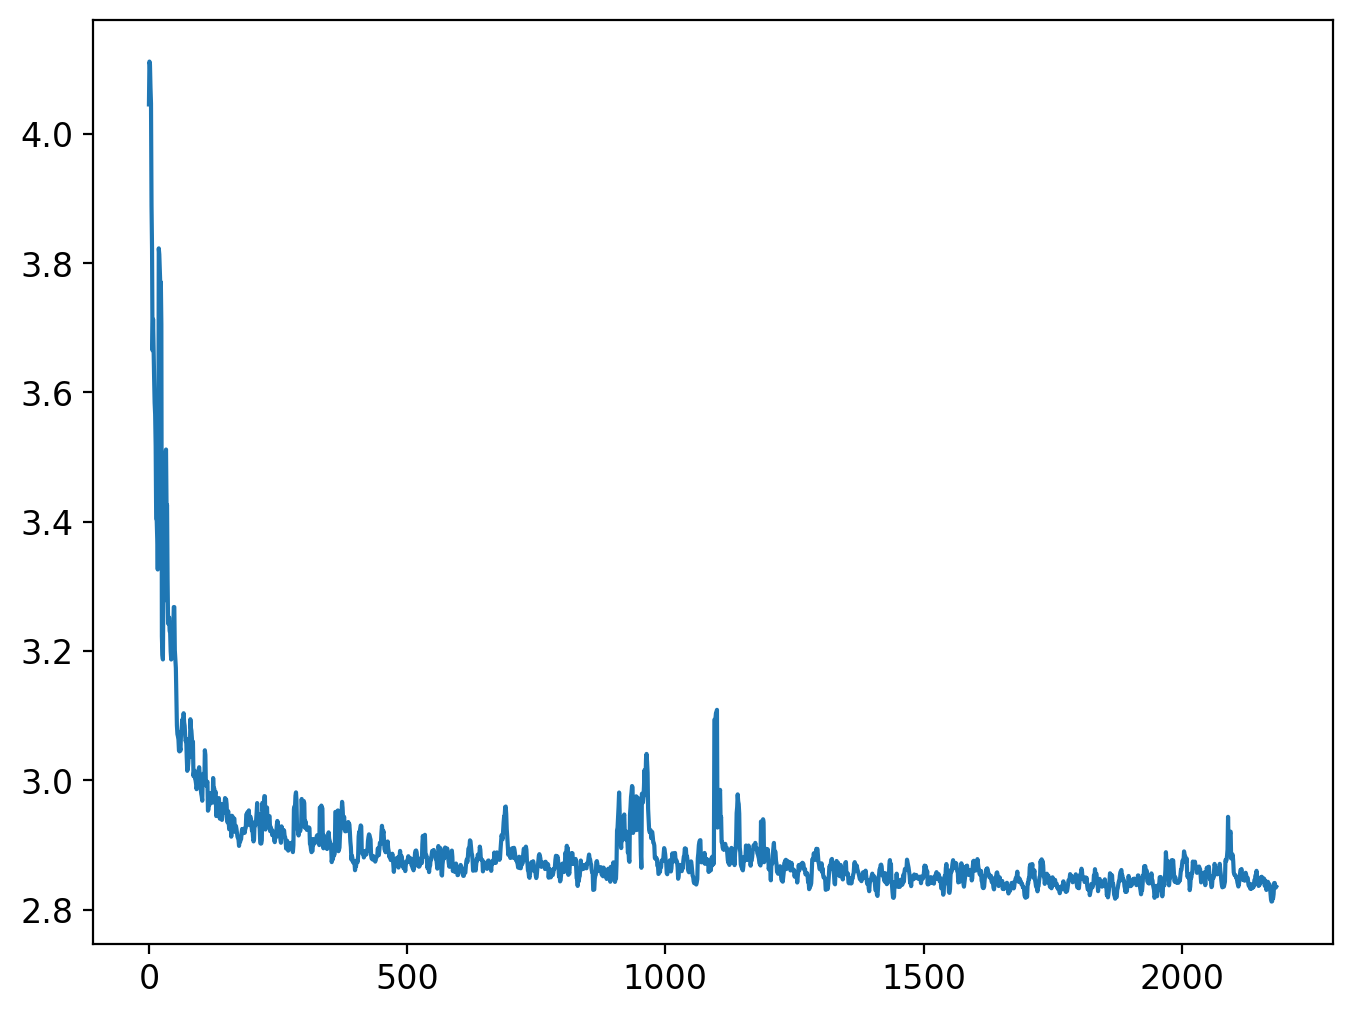

In [26]:
flow = flow.to(device)
flow = trainFlow(flow,train_data,context=train_mass,n_epoch=70,lr=1e-4,bs=4096,wd=0.0,patience=-1,n_avg=100,anneal=True)
torch.save(flow,"/nobackup/users/derickfm/RQSNFnorm1500flatmass_v3_largeBatch.pt")

In [10]:
'''
def loss_mass_cut(loss1,loss2,lower_bound,upper_bound, mass = train_mass_tmp):
    loss1 = ak.from_numpy(loss1)
    loss2 = ak.from_numpy(loss2)
    #mass = ak.from_numpy(mass)
    mass_cut = np.logical_and(mass>lower_bound,mass<=upper_bound)
    loss1 = loss1[mass_cut]
    loss2 = loss2[mass_cut]
    loss1 = np.array(loss1)
    loss2 = np.array(loss2)
    return loss1, loss2  

#Quak Space    
plot_quak(train_loss2,train_loss1,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',title="QUAK Space")
#loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,1500,2000)
#plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',title="QUAK Space(1500-2000)")
#loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,2100,2500)
#plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',title="QUAK Space(2100-2500)")
loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,2800,3200)
plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',title="QUAK Space(2800-3200)")
loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,3400,3800)
plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',title="QUAK Space(3400-3800)")


bkg_mean = []
bkg_std = []
sig_mean = []
sig_std = []
#Reconstructed Space
tmp = reconstruct_mass_range(flow, train_mass_tmp,val_mass,title='Reconstructed Space')
reconstruct_mass_range(flow, train_mass_tmp,val_mass,lower_bound = 1500, upper_bound = 2000,title='Reconstructed Space (1500-2000)')
#reconstruct_mass_range(flow, train_mass_tmp,val_mass,lower_bound = 2100, upper_bound = 2500,title='Reconstructed Space (2100-2500)')
tmp = reconstruct_mass_range(flow, train_mass_tmp,val_mass,lower_bound = 2800, upper_bound = 3200,title='Reconstructed Space (2800-3200)')
bkg_mean.append(tmp[0])
bkg_std.append(tmp[1])
sig_mean.append(tmp[2])
sig_std.append(tmp[3])
tmp = reconstruct_mass_range(flow, train_mass_tmp,val_mass,lower_bound = 3400, upper_bound = 3800,title='Reconstructed Space (3400-3800)')
bkg_mean.append(tmp[0])
bkg_std.append(tmp[1])
sig_mean.append(tmp[2])
sig_std.append(tmp[3])

print(bkg_mean,bkg_std,sig_mean,sig_std) '''

'\ndef loss_mass_cut(loss1,loss2,lower_bound,upper_bound, mass = train_mass_tmp):\n    loss1 = ak.from_numpy(loss1)\n    loss2 = ak.from_numpy(loss2)\n    #mass = ak.from_numpy(mass)\n    mass_cut = np.logical_and(mass>lower_bound,mass<=upper_bound)\n    loss1 = loss1[mass_cut]\n    loss2 = loss2[mass_cut]\n    loss1 = np.array(loss1)\n    loss2 = np.array(loss2)\n    return loss1, loss2  \n\n#Quak Space    \nplot_quak(train_loss2,train_loss1,xlim=[-3,3],ylim=[-3,3],ylabel=\'Signal Loss\',xlabel=\'Background Loss\',title="QUAK Space")\n#loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,1500,2000)\n#plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel=\'Signal Loss\',xlabel=\'Background Loss\',title="QUAK Space(1500-2000)")\n#loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,2100,2500)\n#plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel=\'Signal Loss\',xlabel=\'Background Loss\',title="QUAK Space(2100-2500)")\nloss1_cut,loss2_cut = loss_mass_cut(tr

In [22]:
#flflow = torch.load("/nobackup/users/derickfm/RQSNFnorm1500_v5_largeBatch.pt")

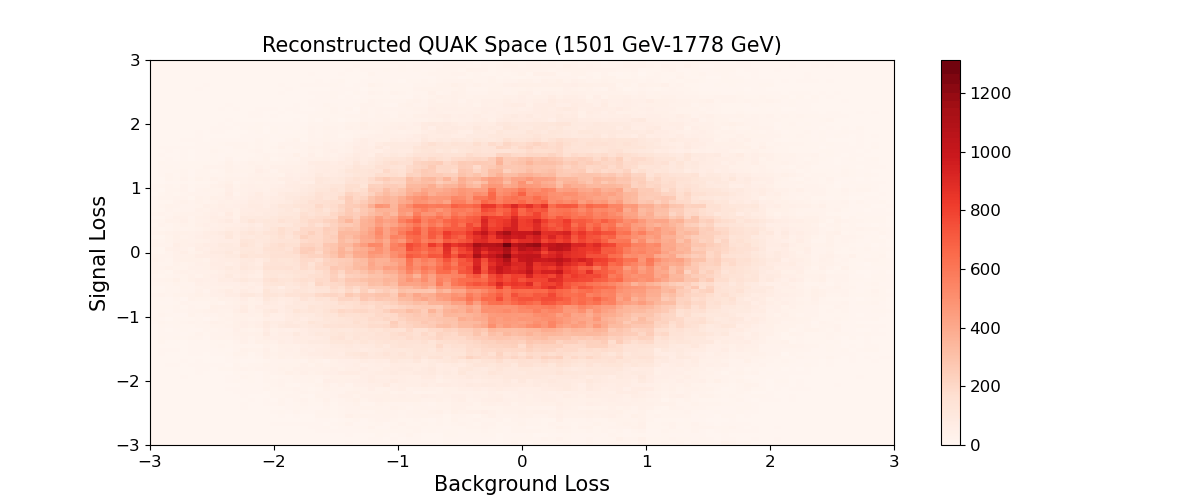

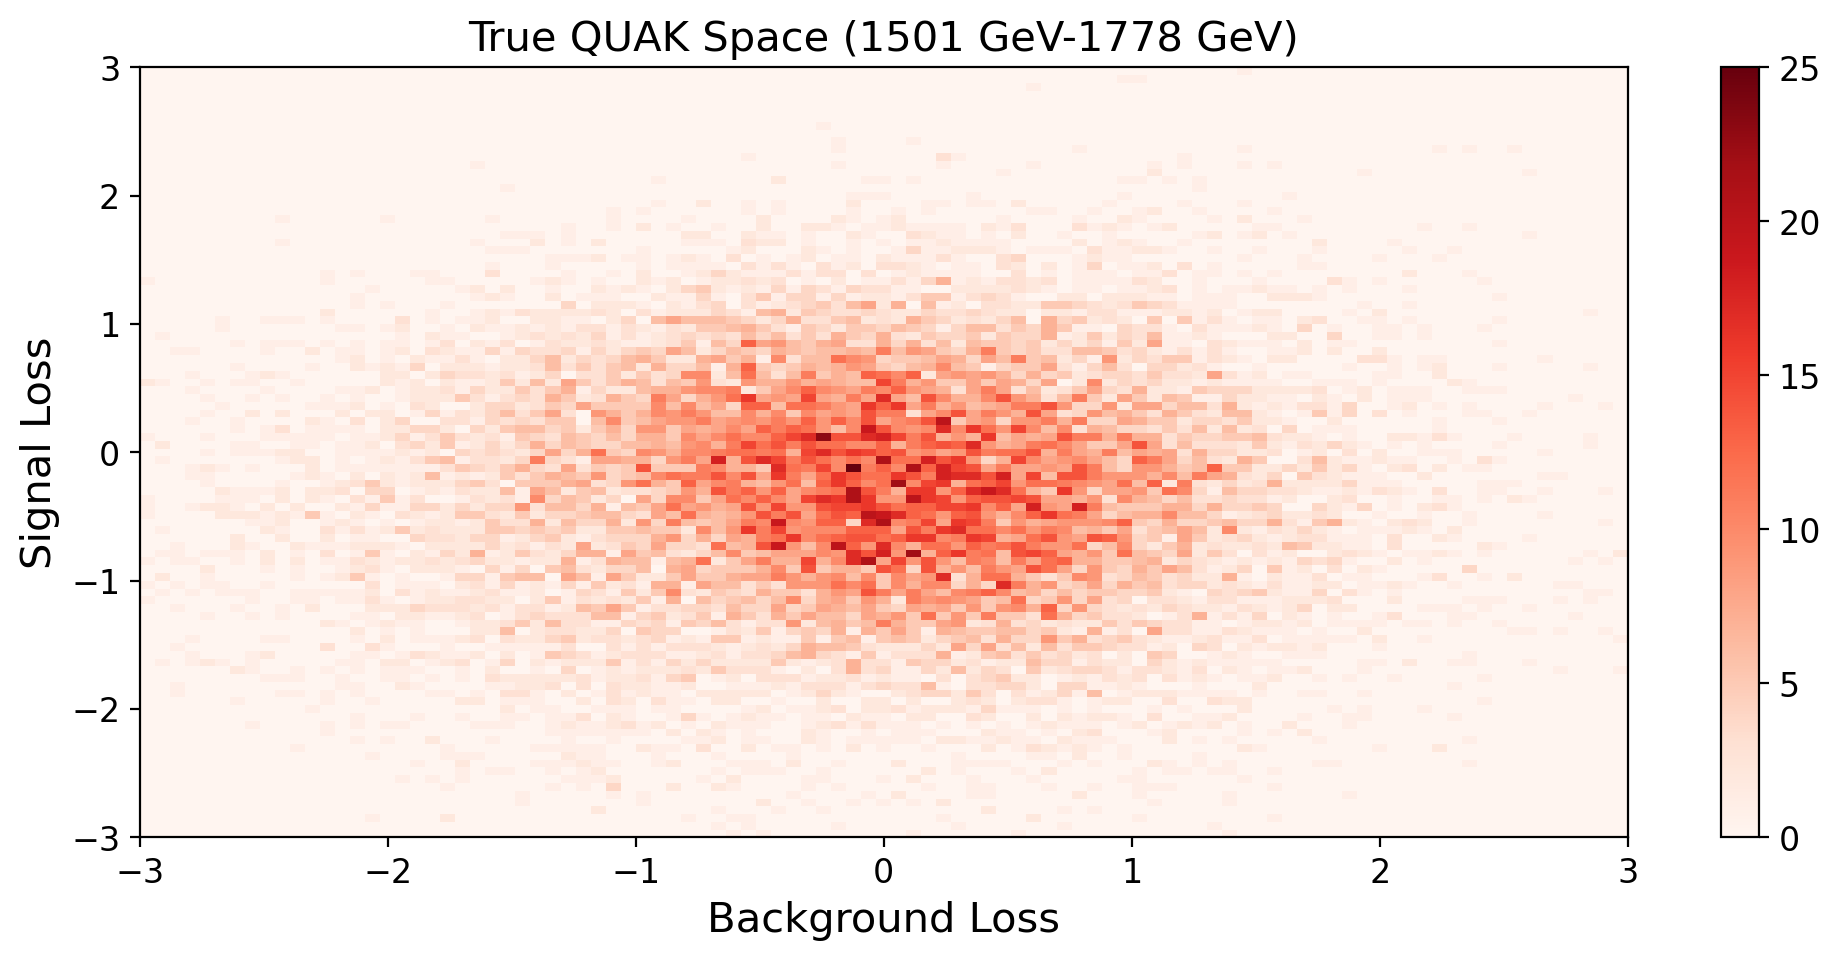

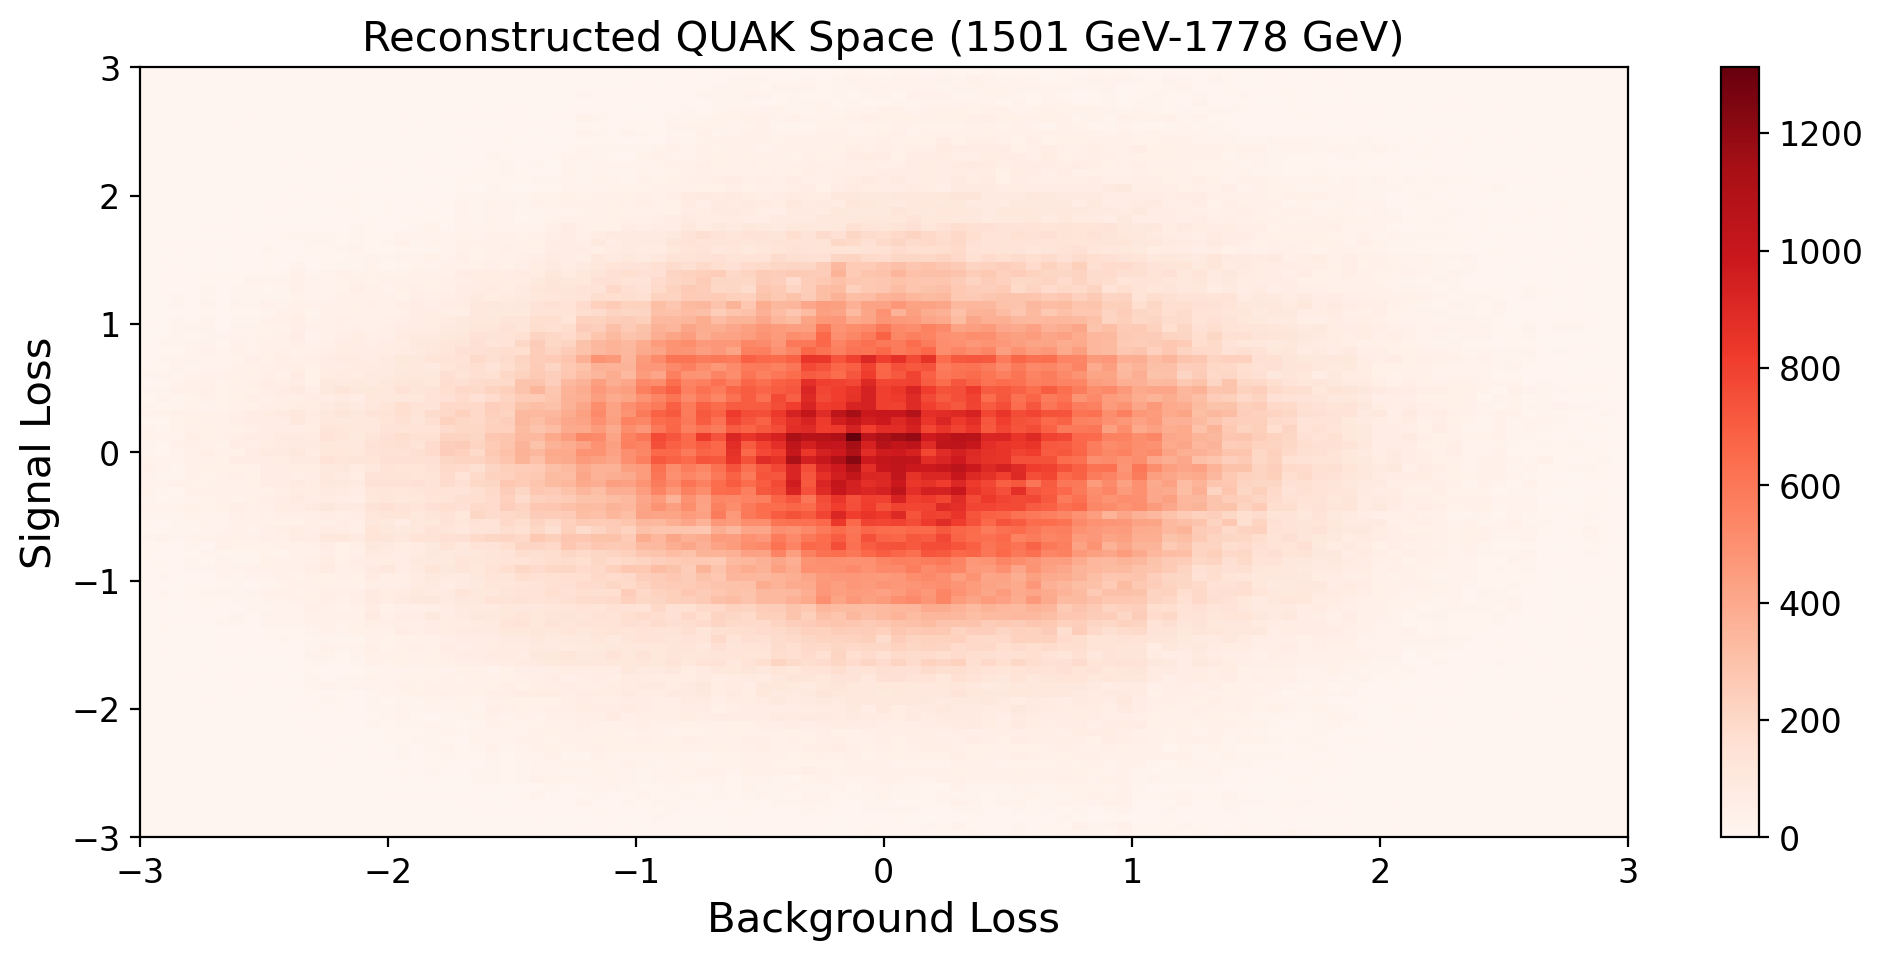

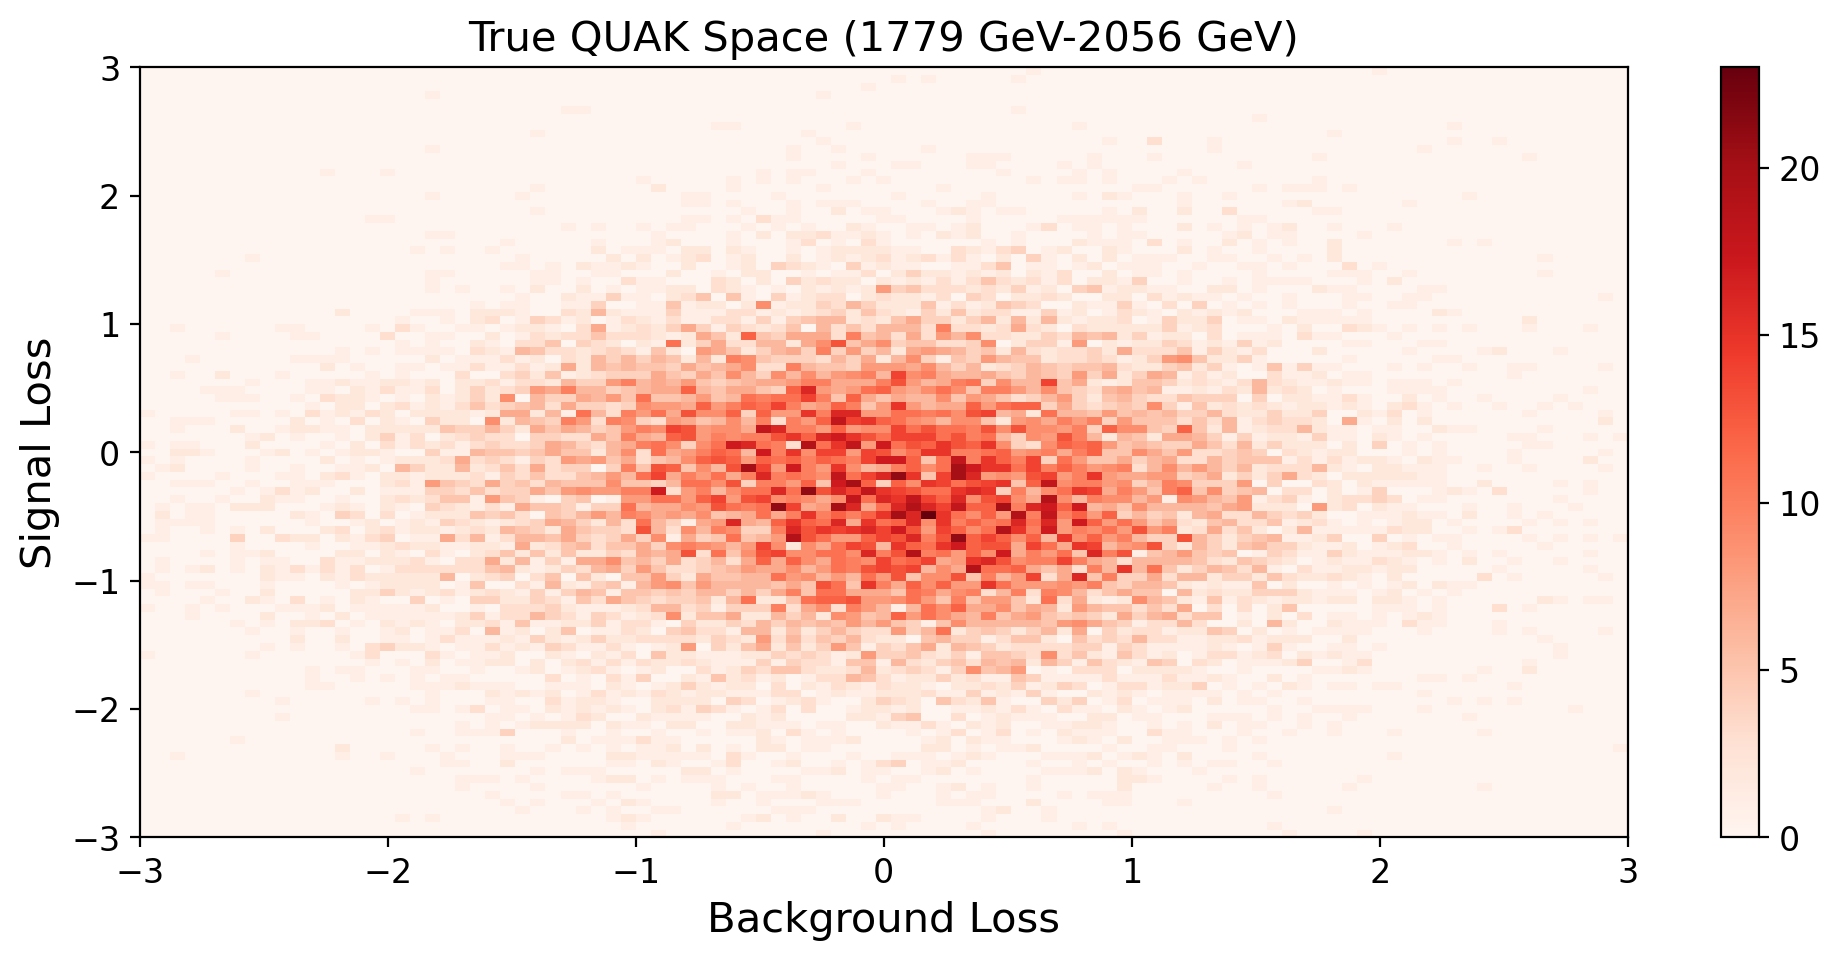

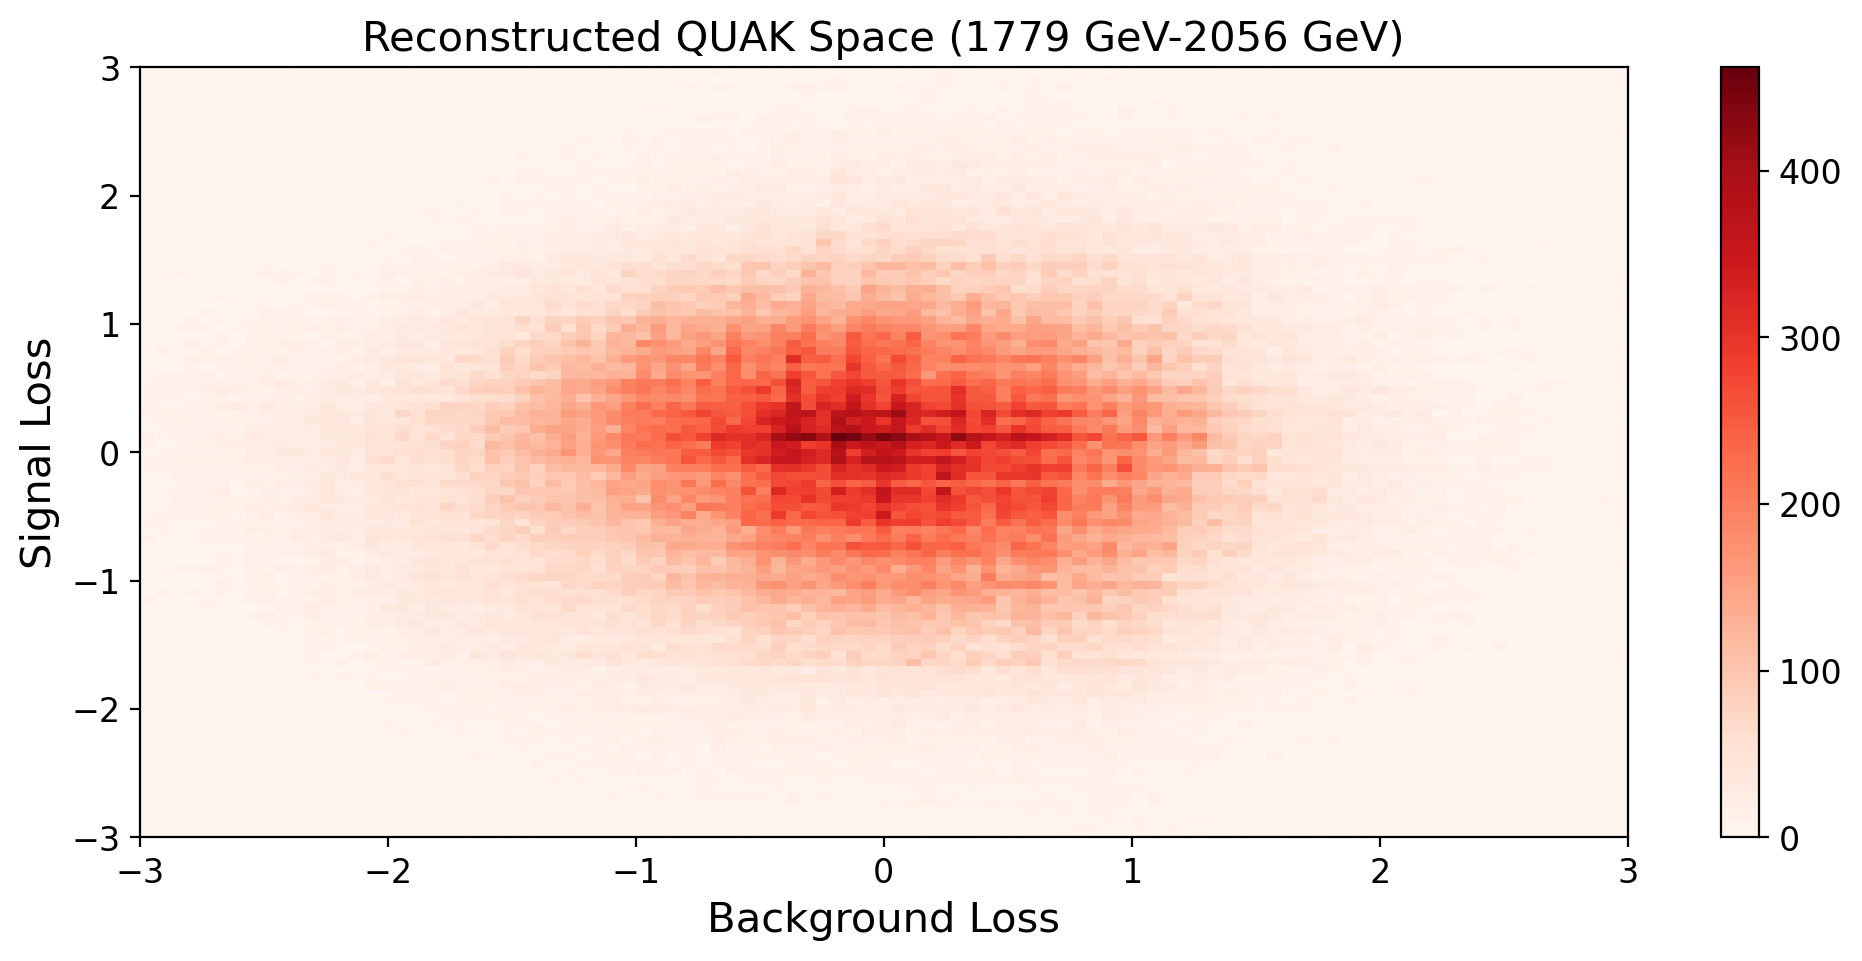

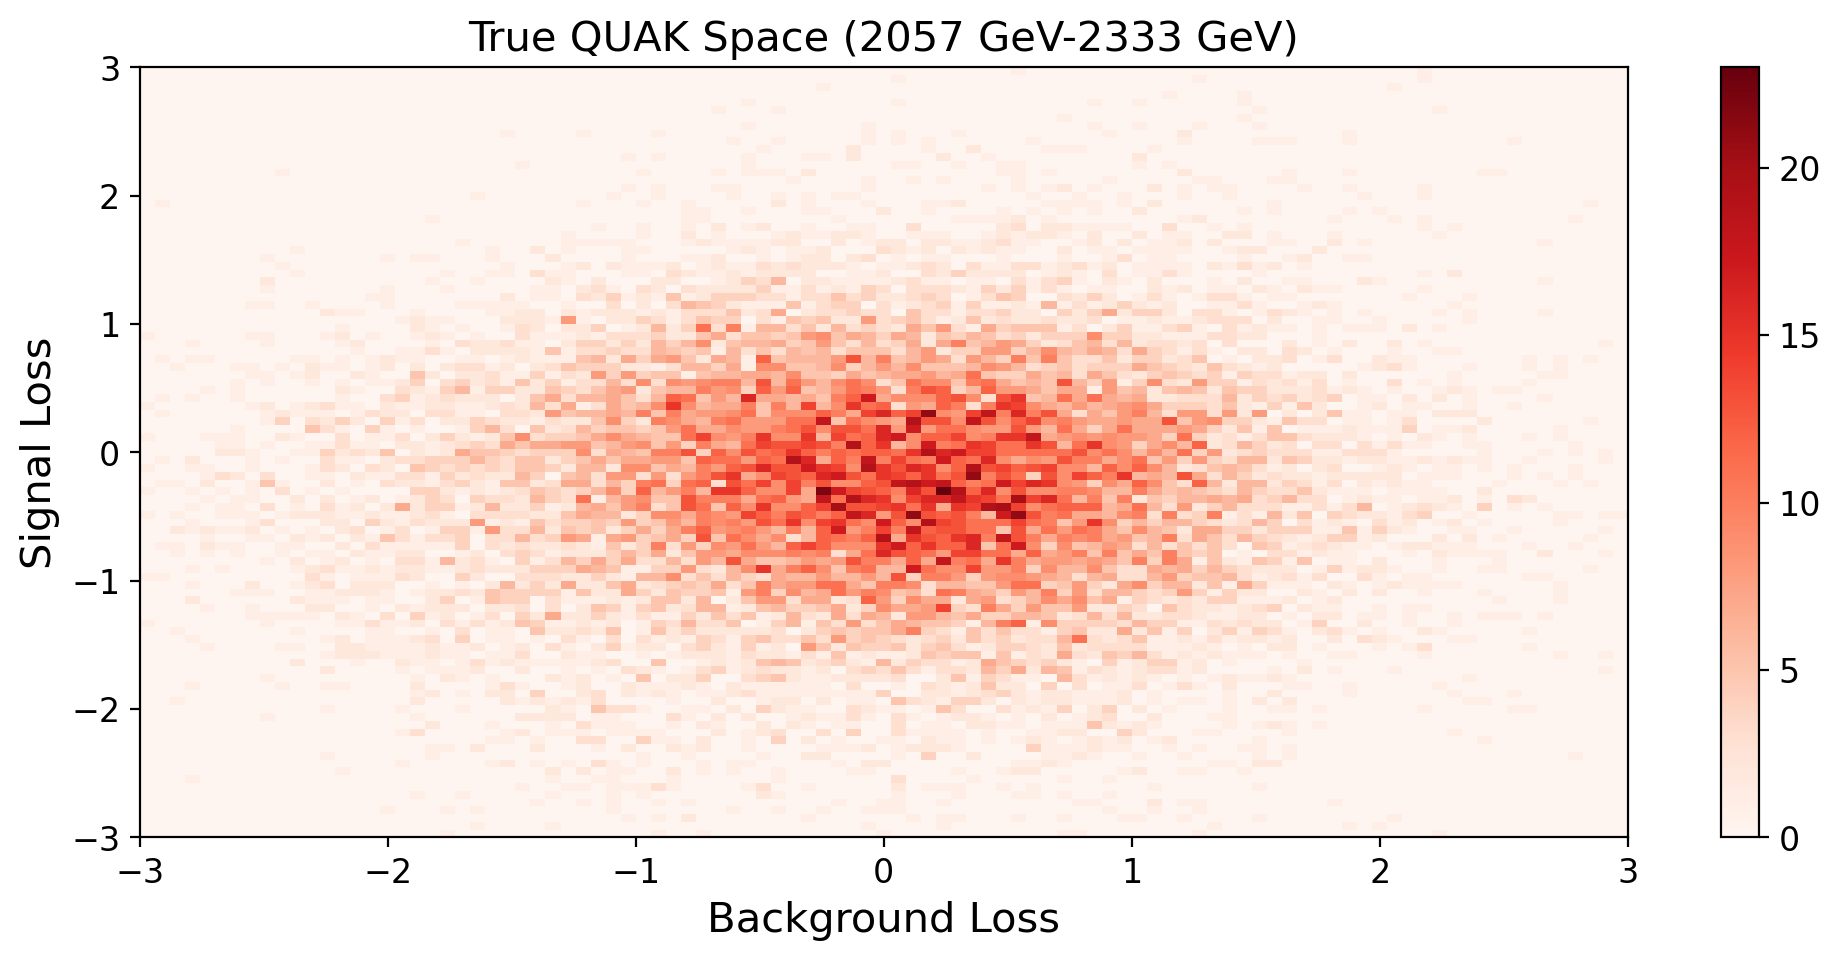

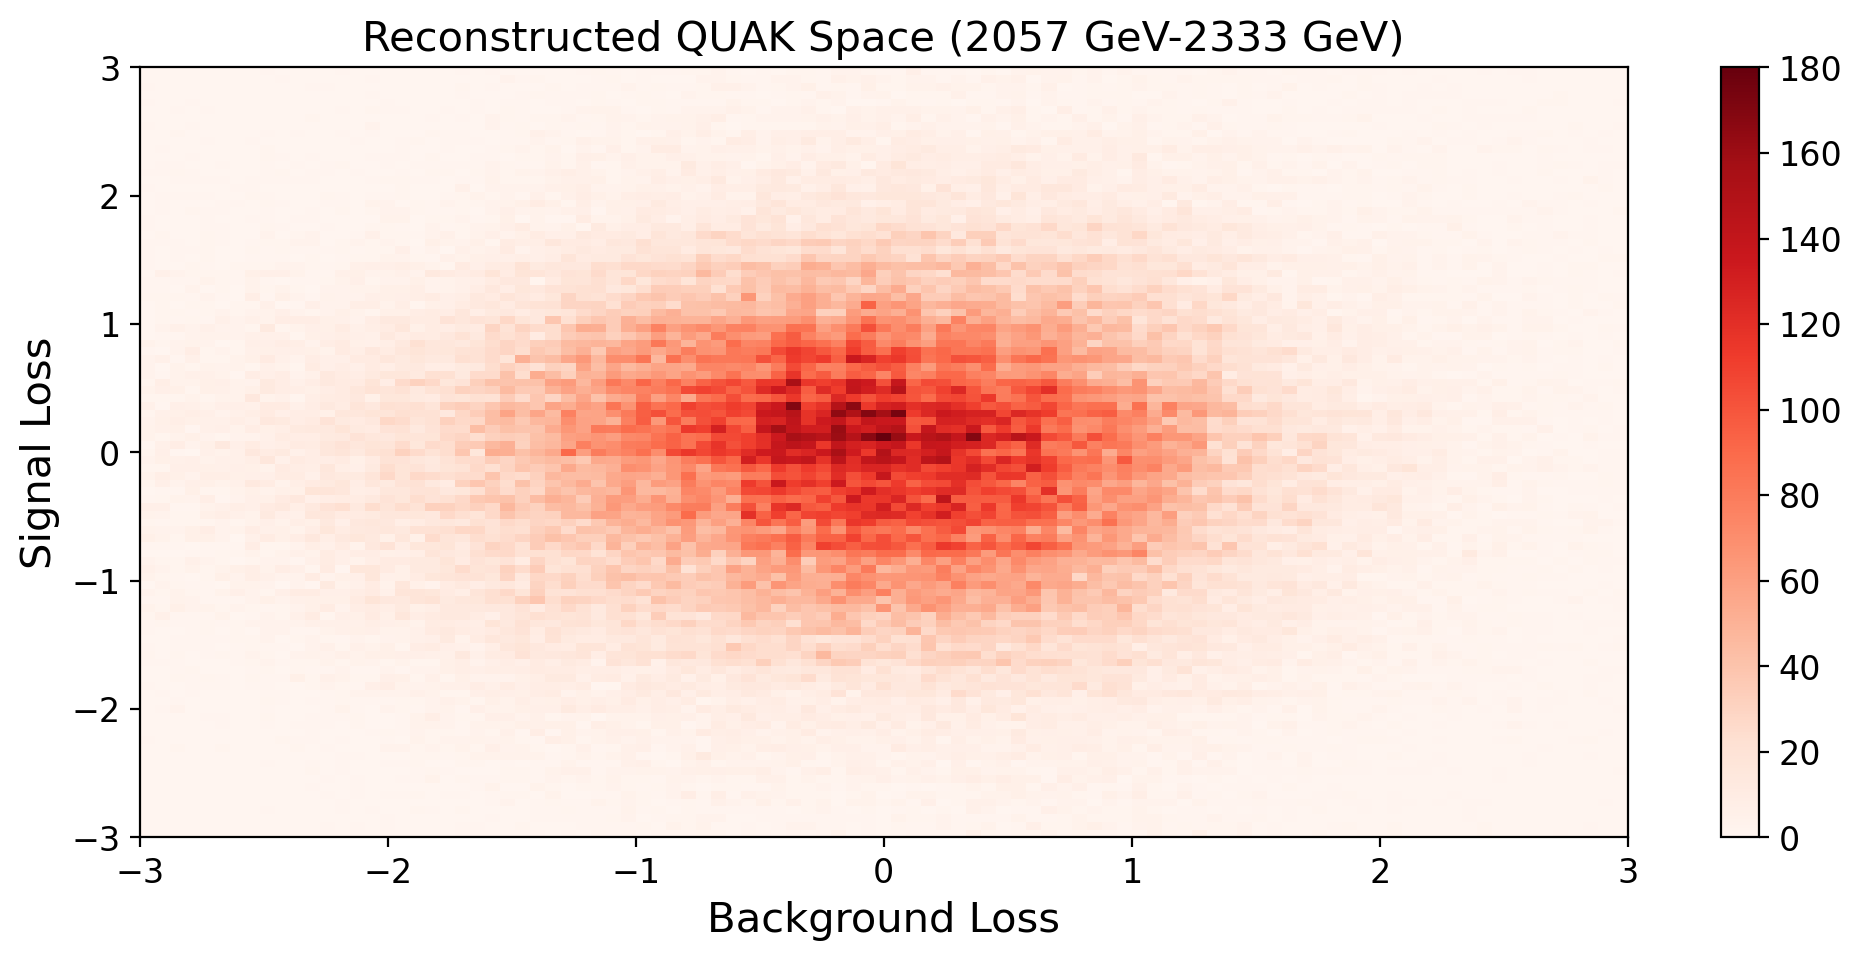

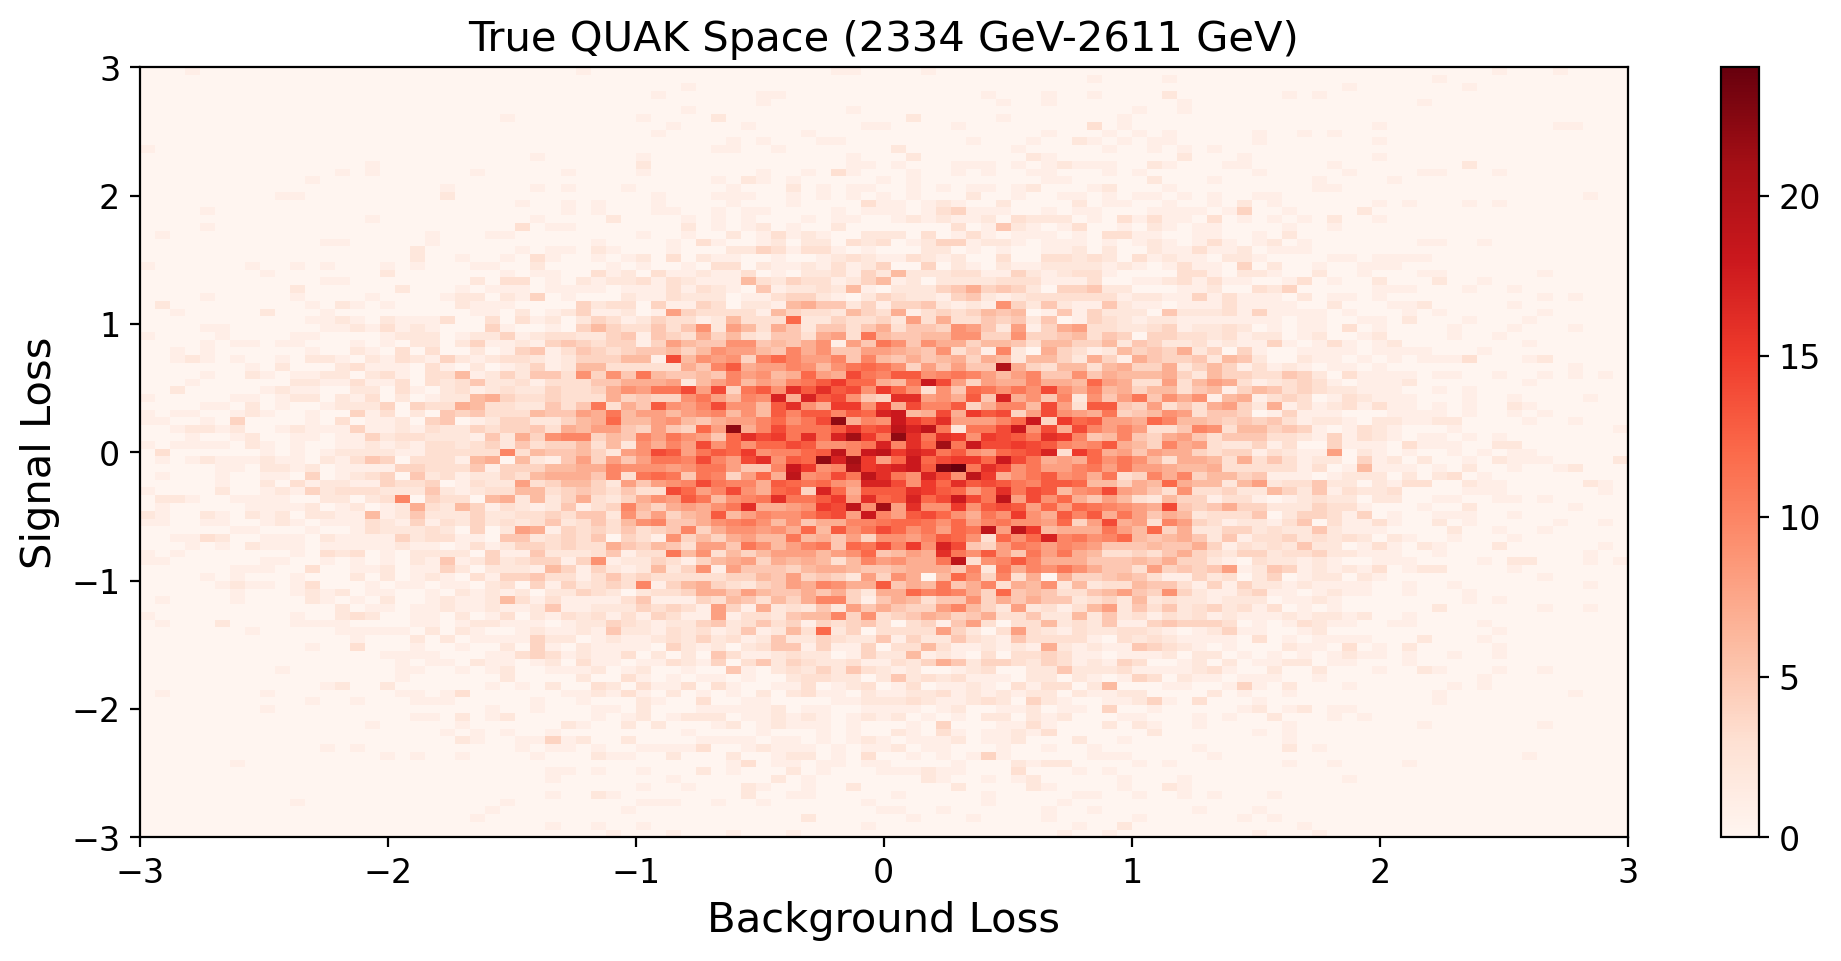

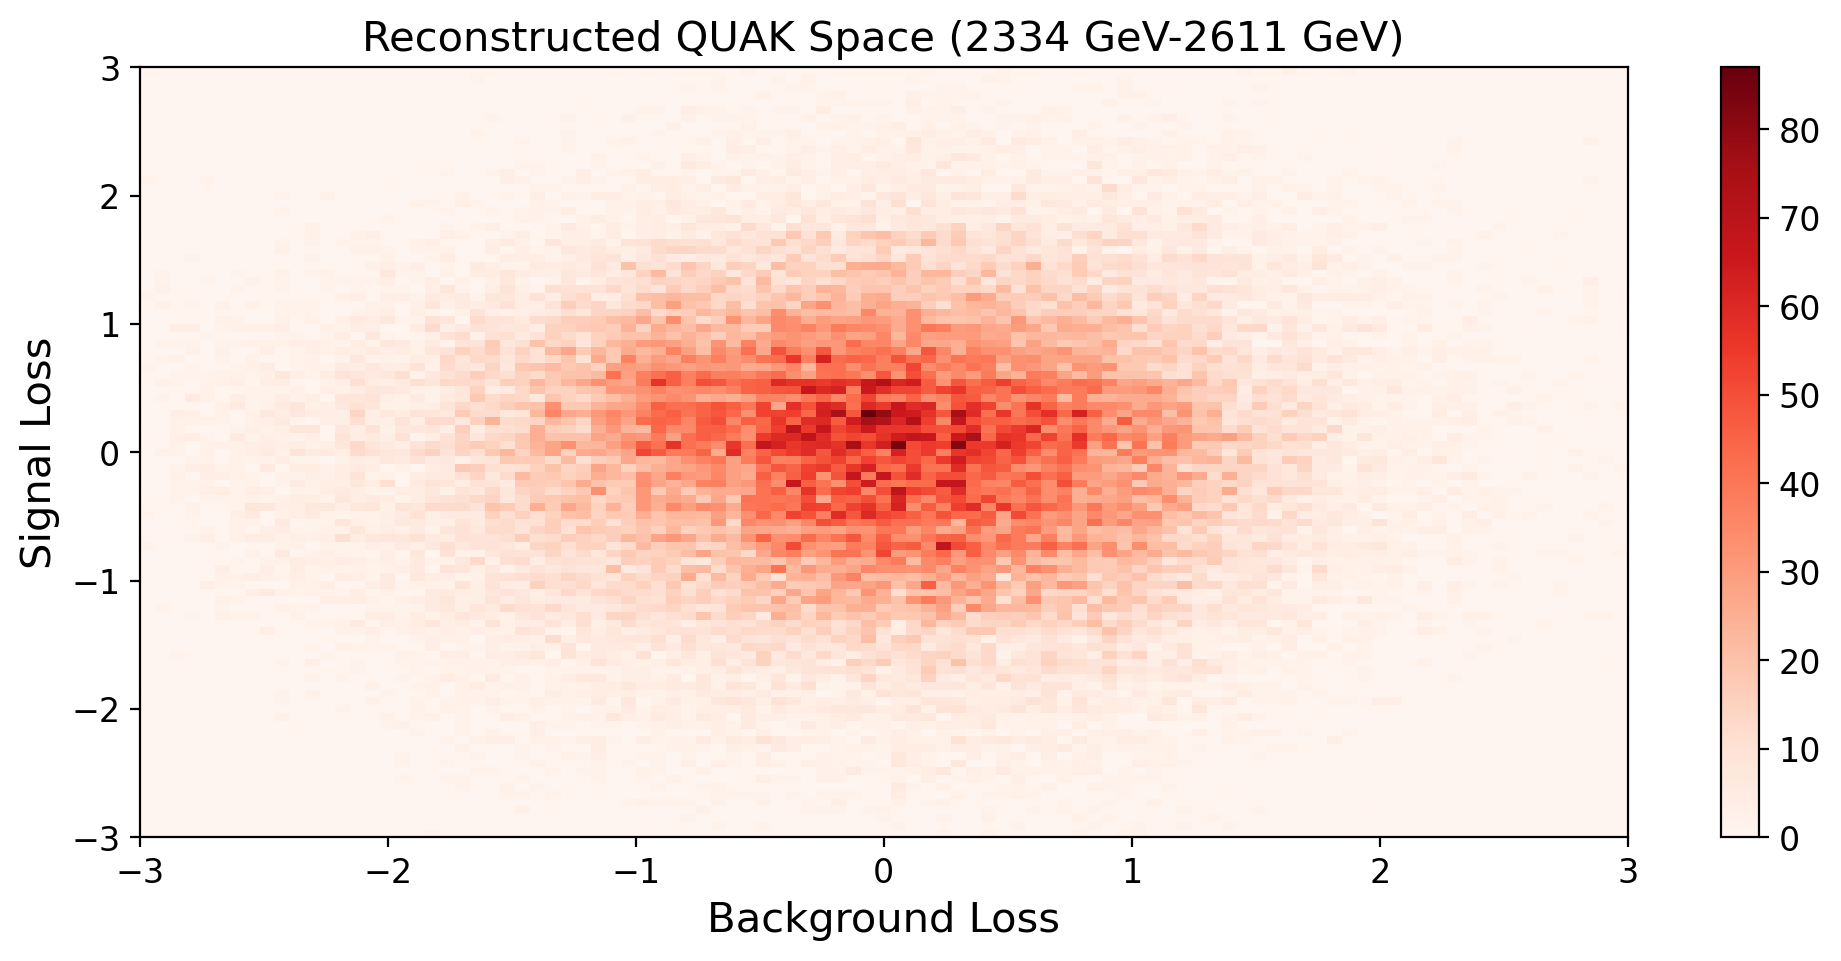

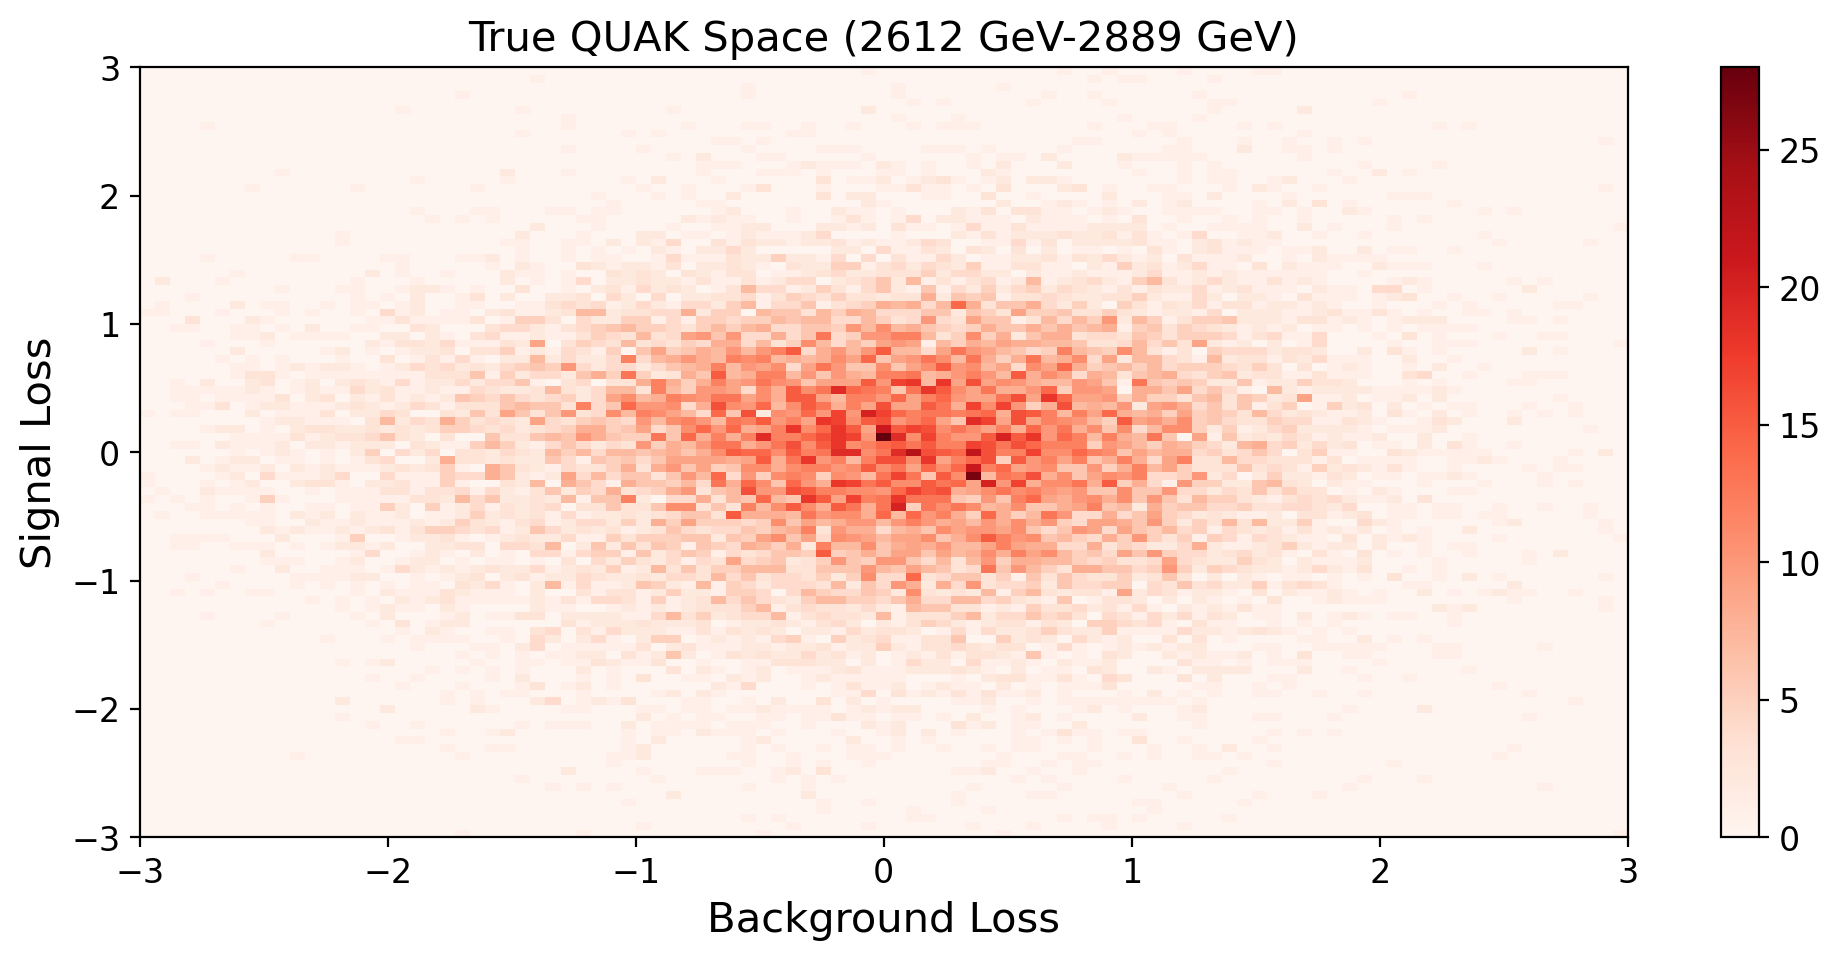

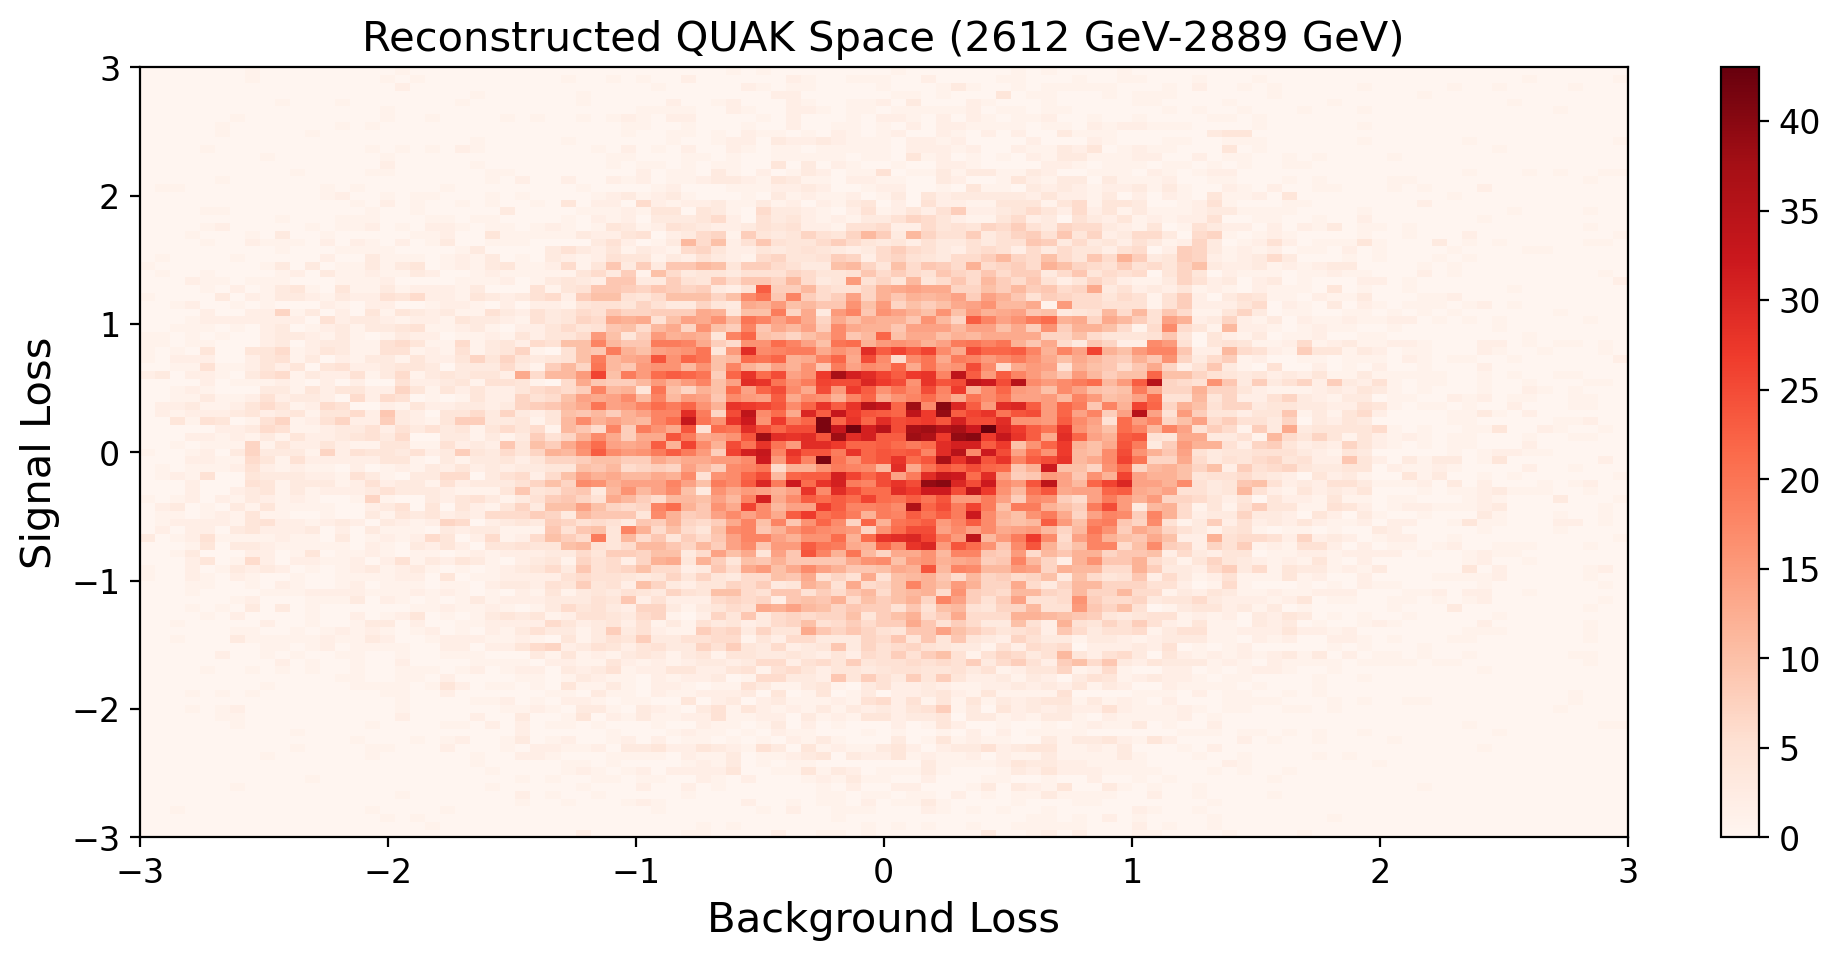

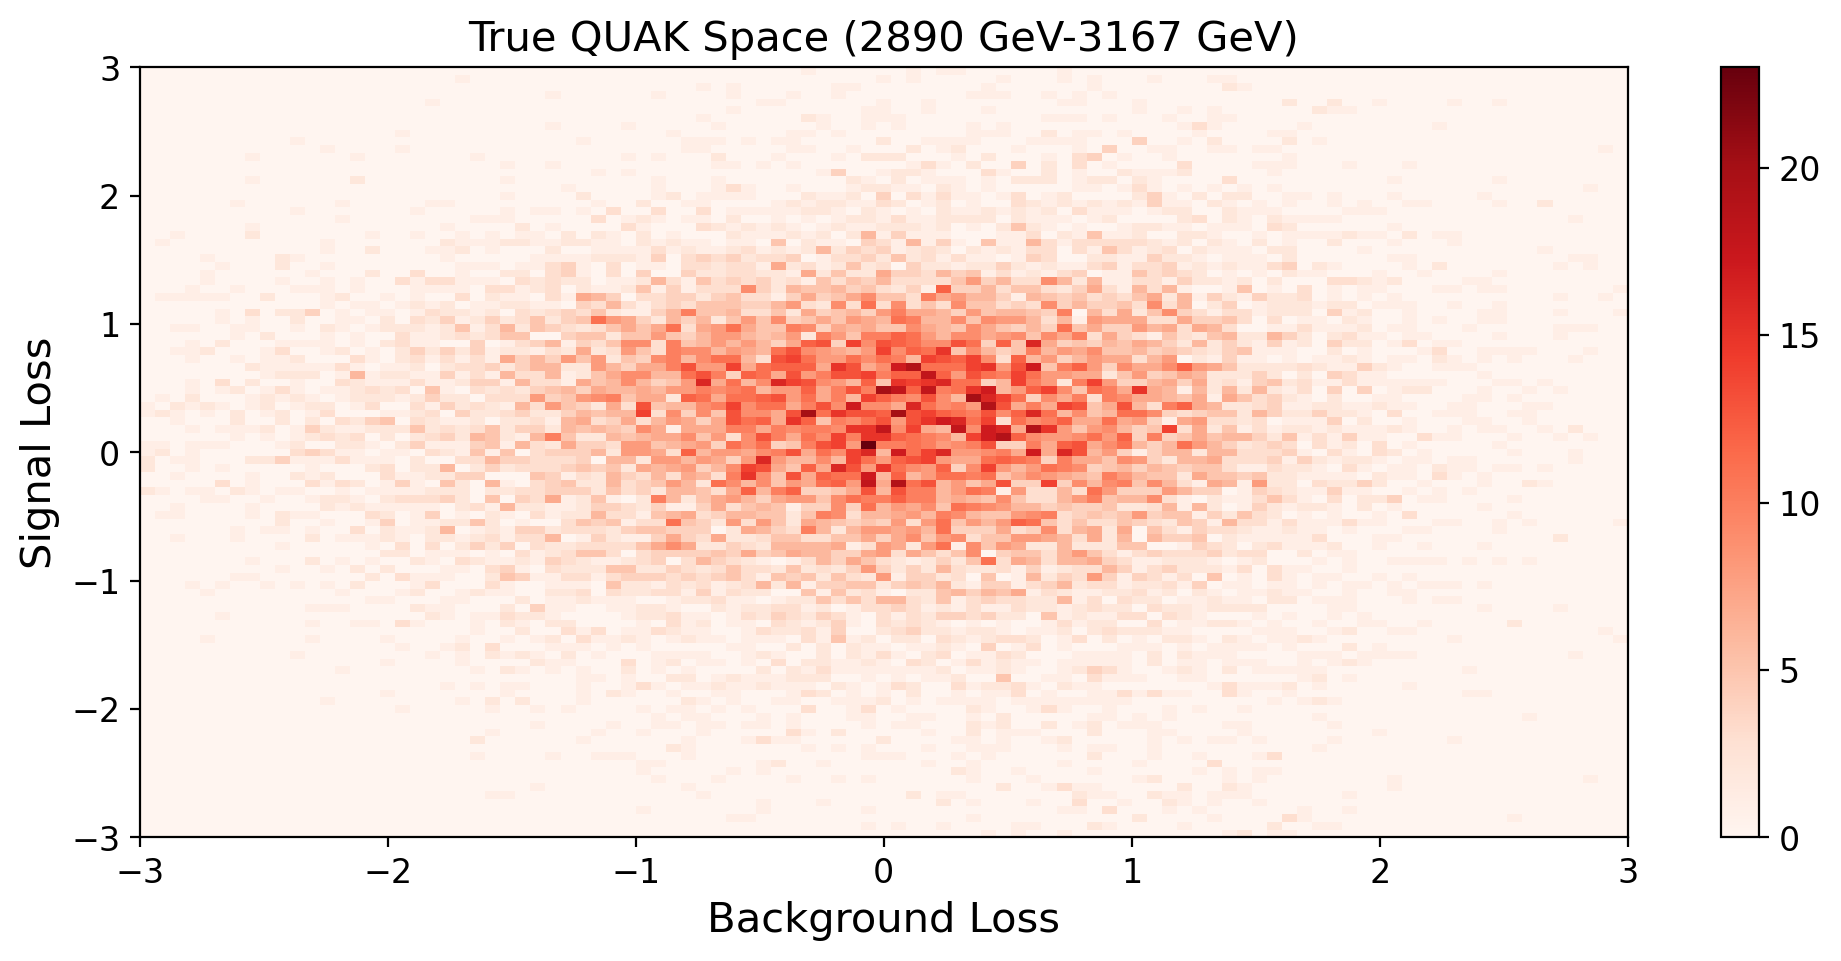

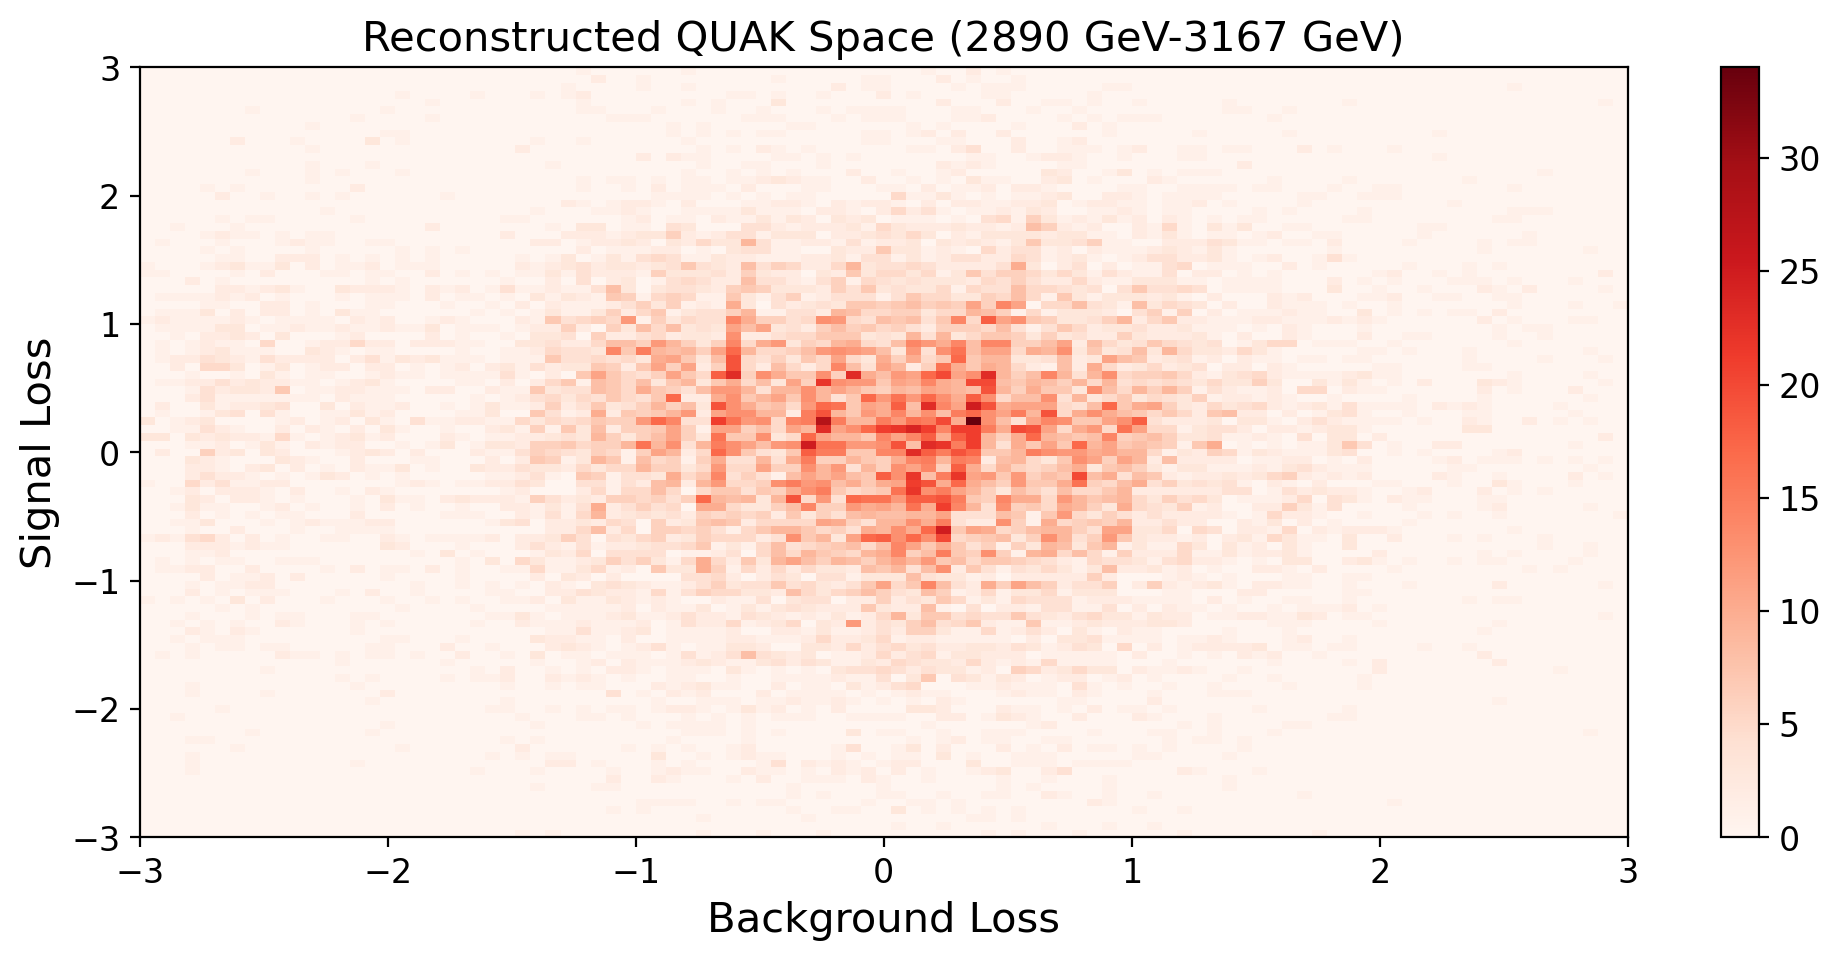

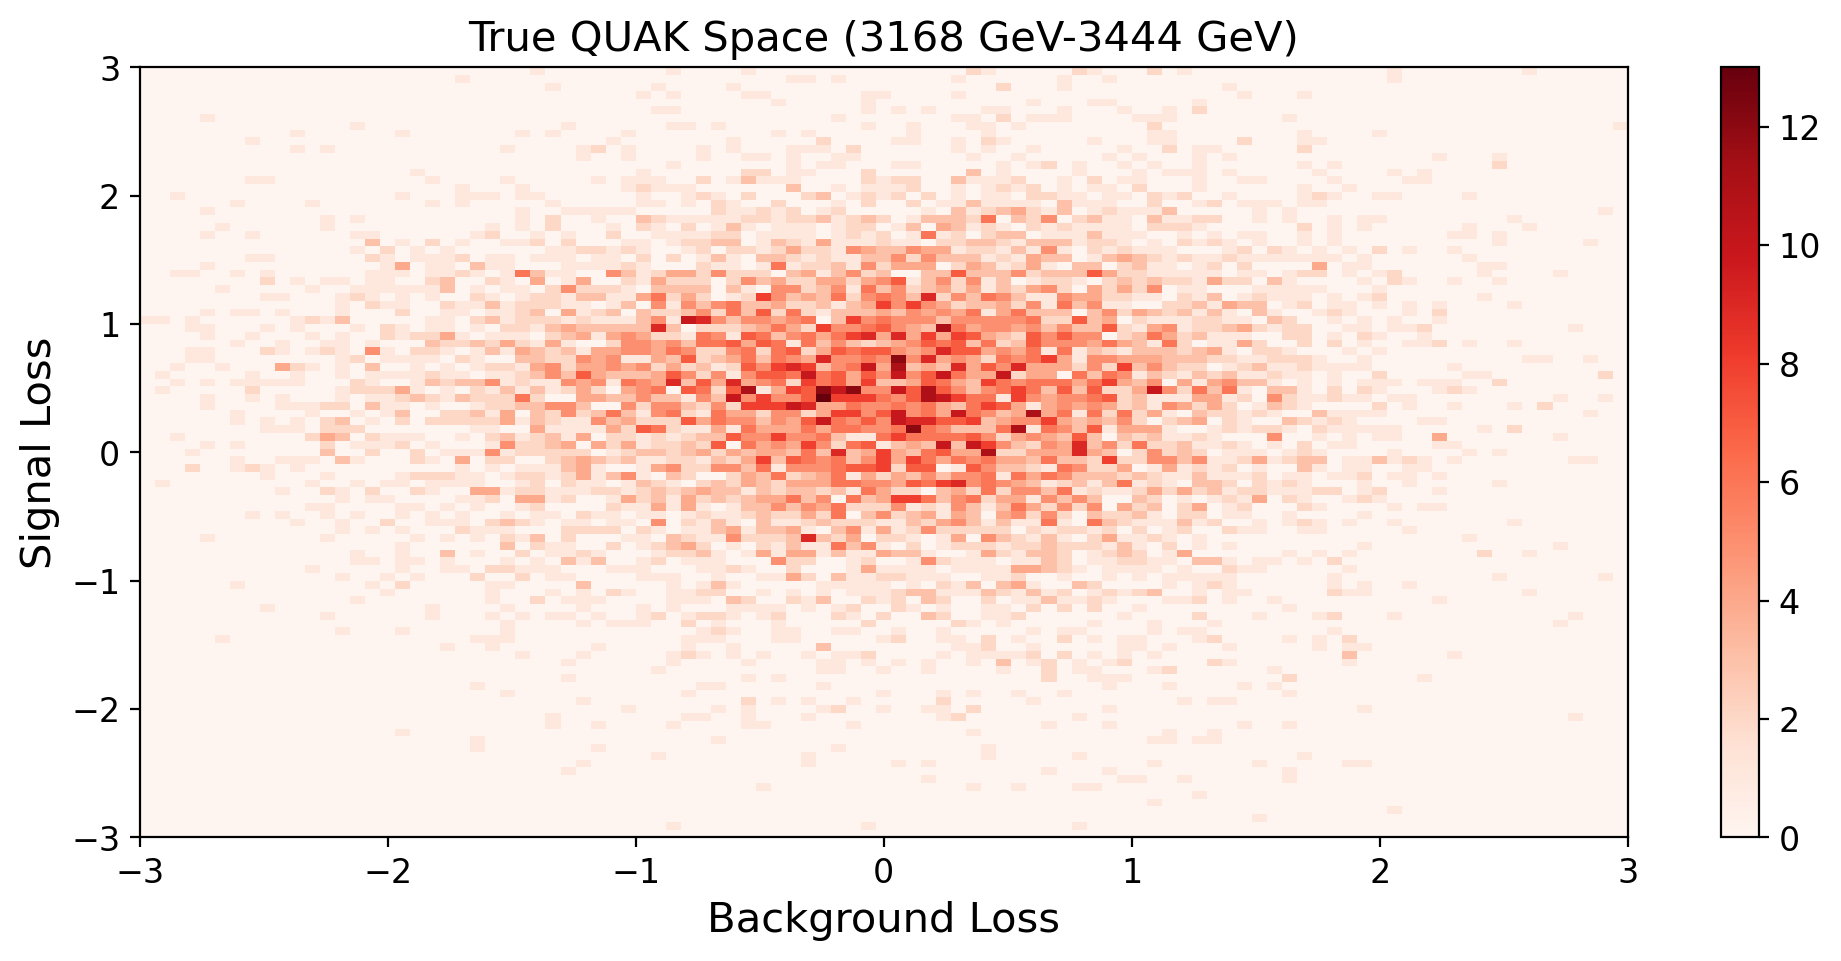

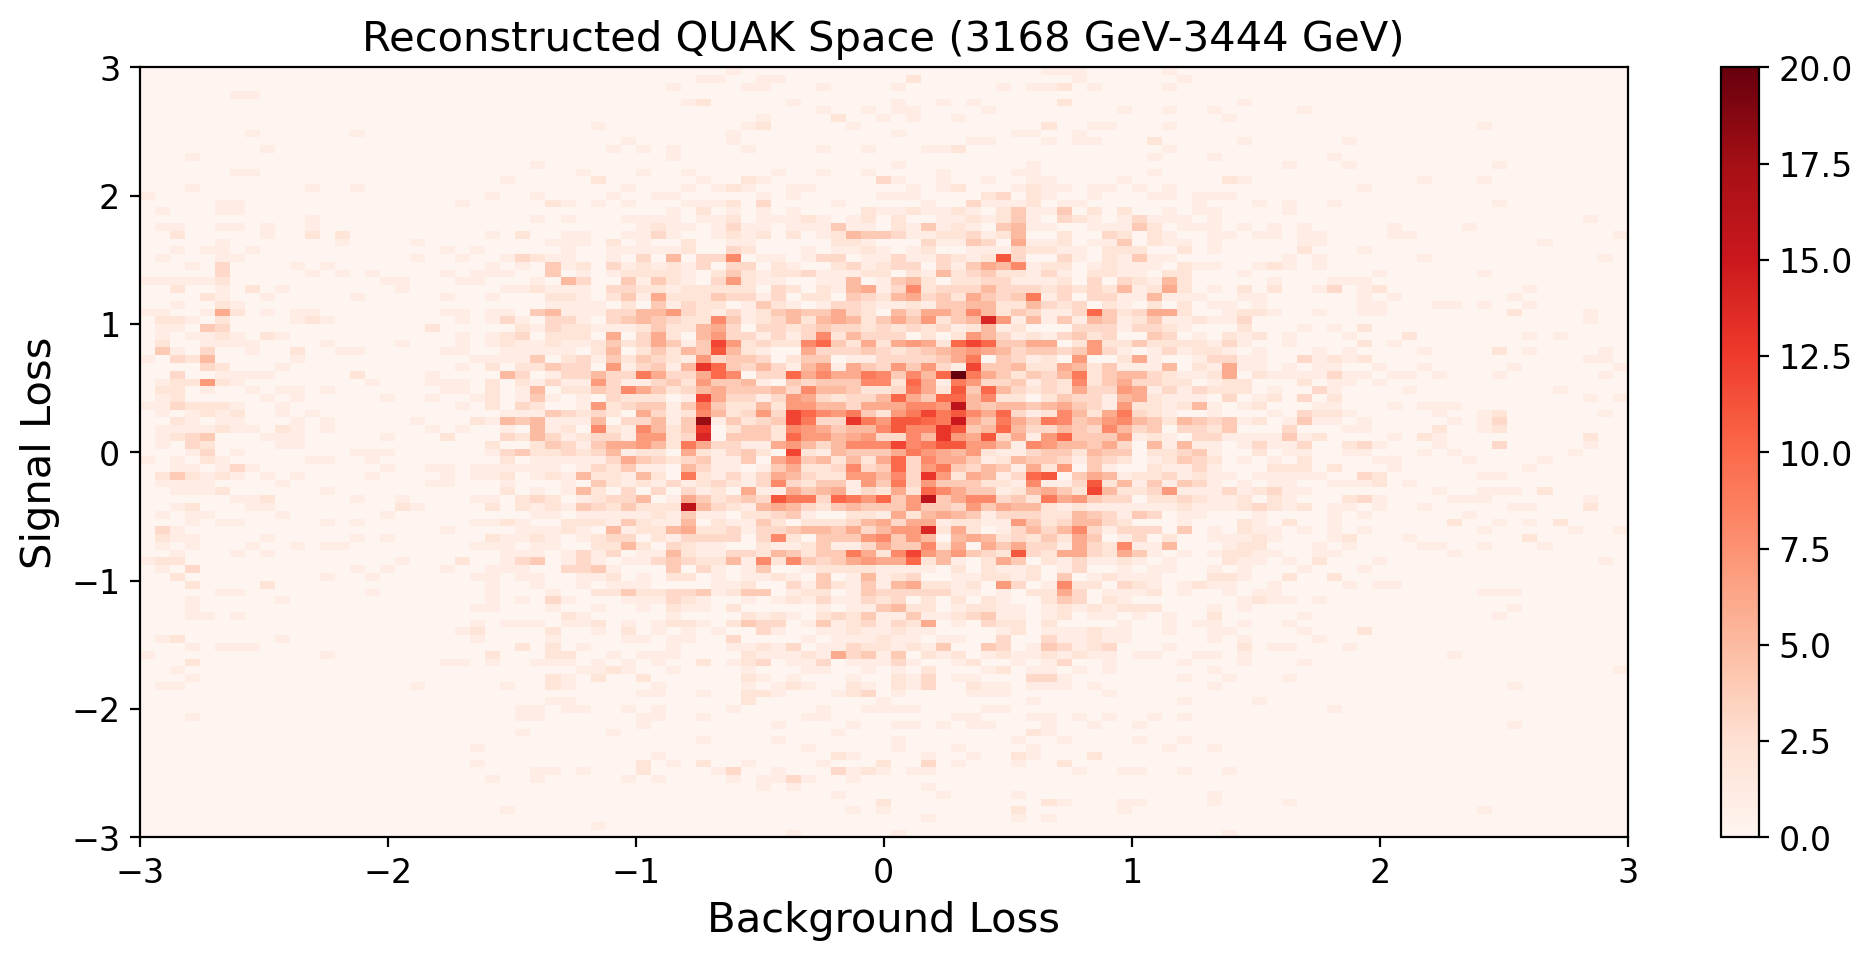

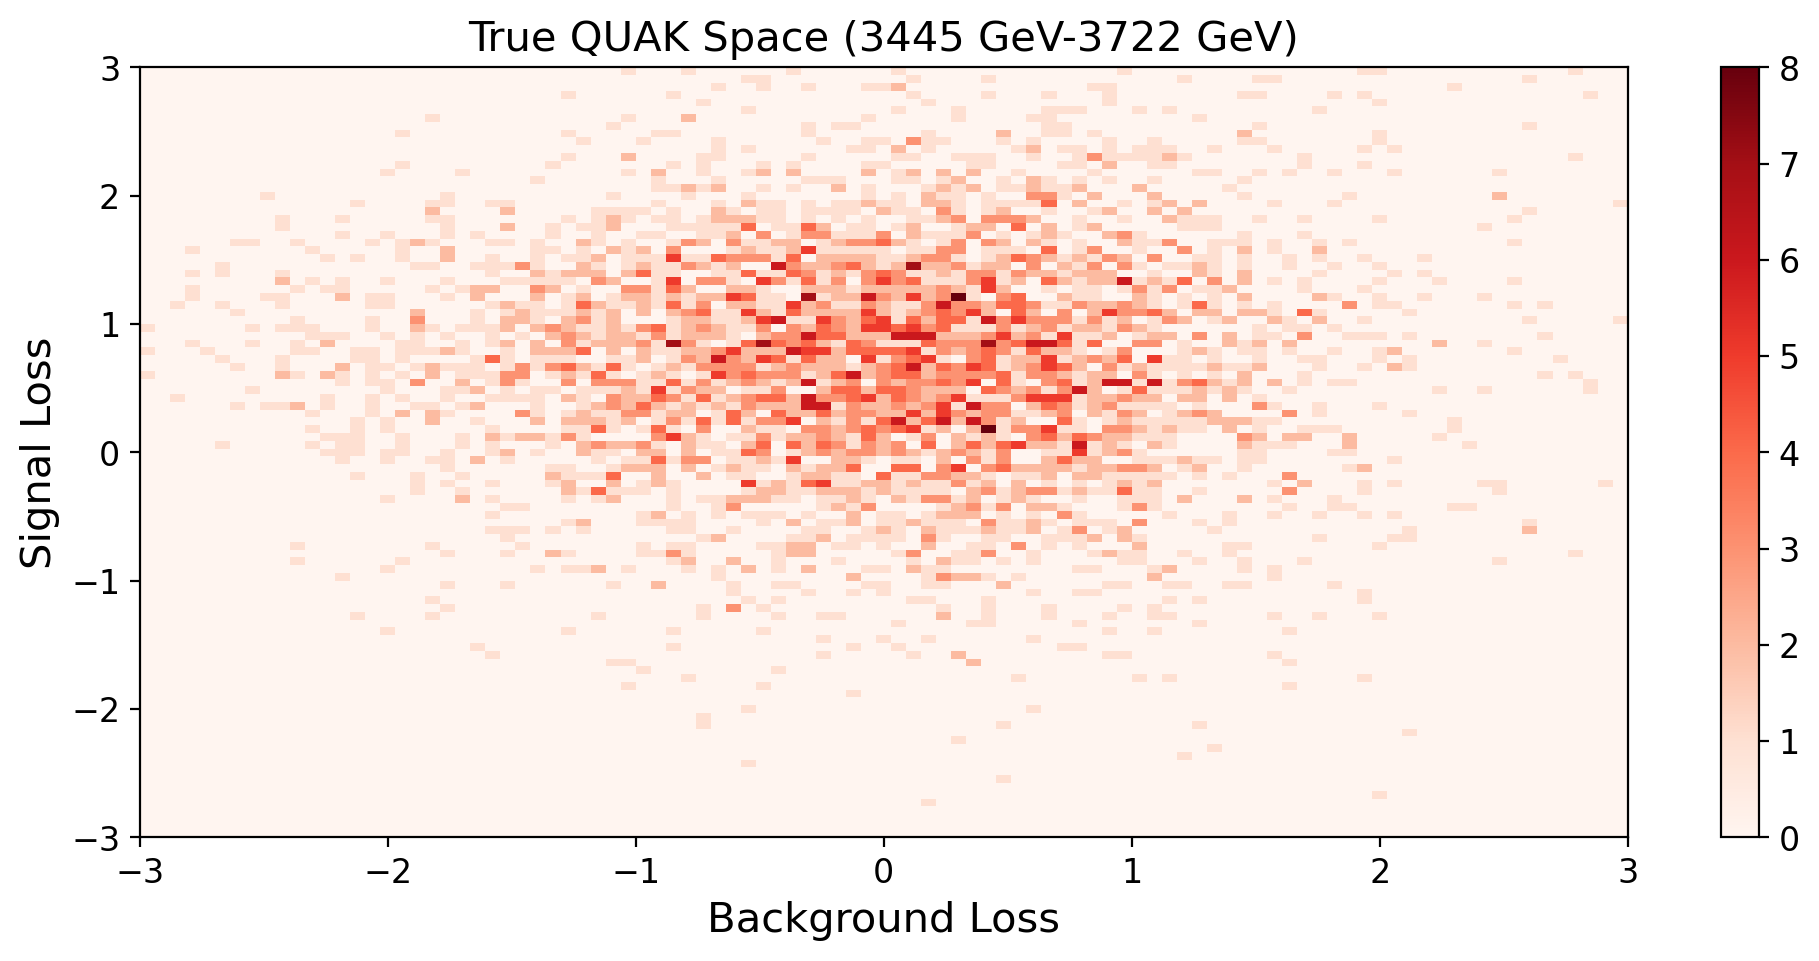

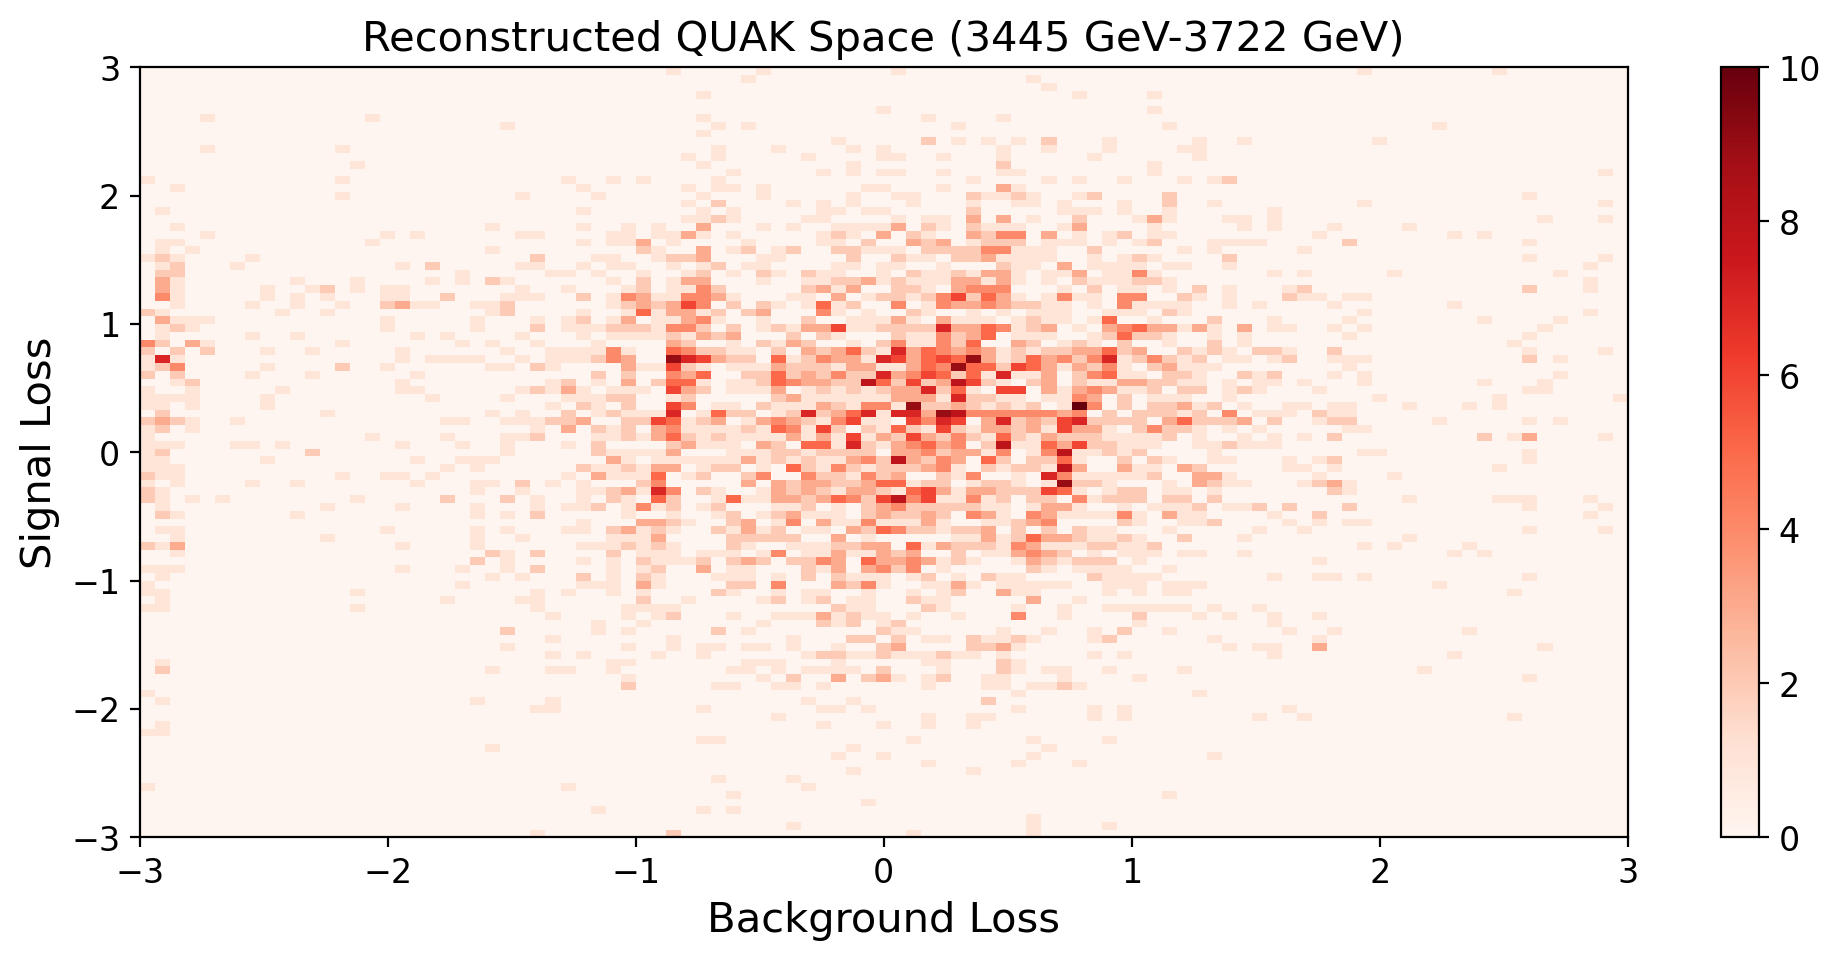

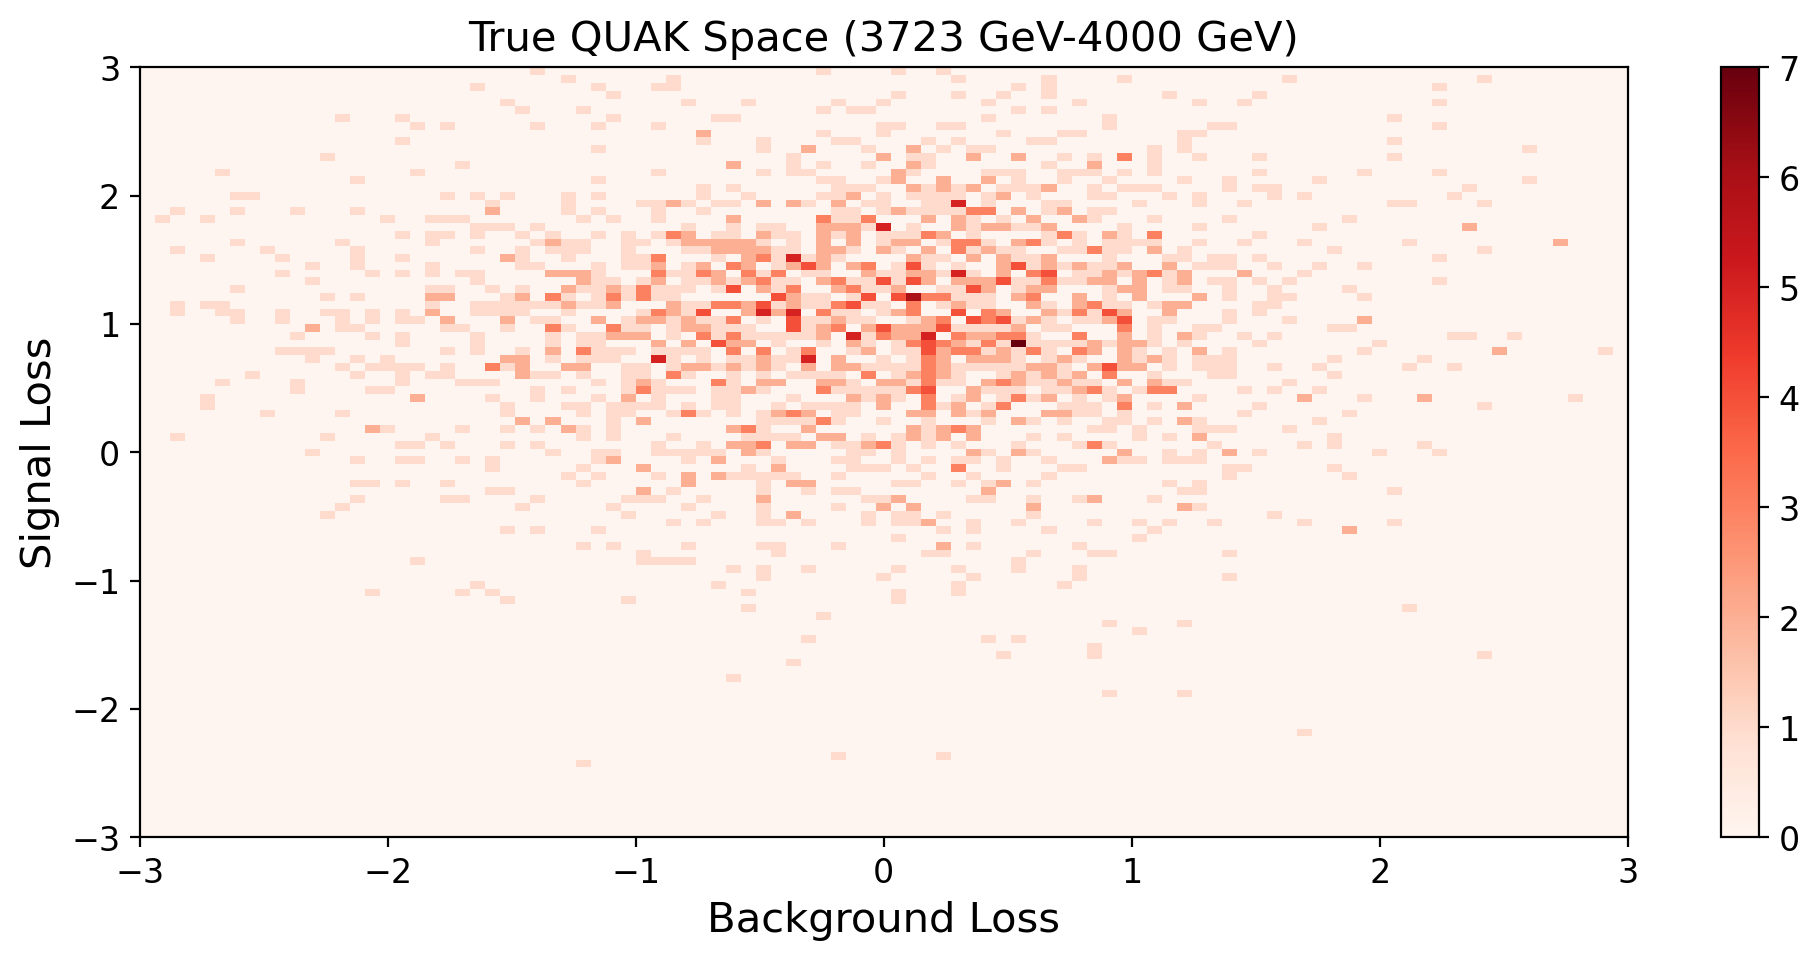

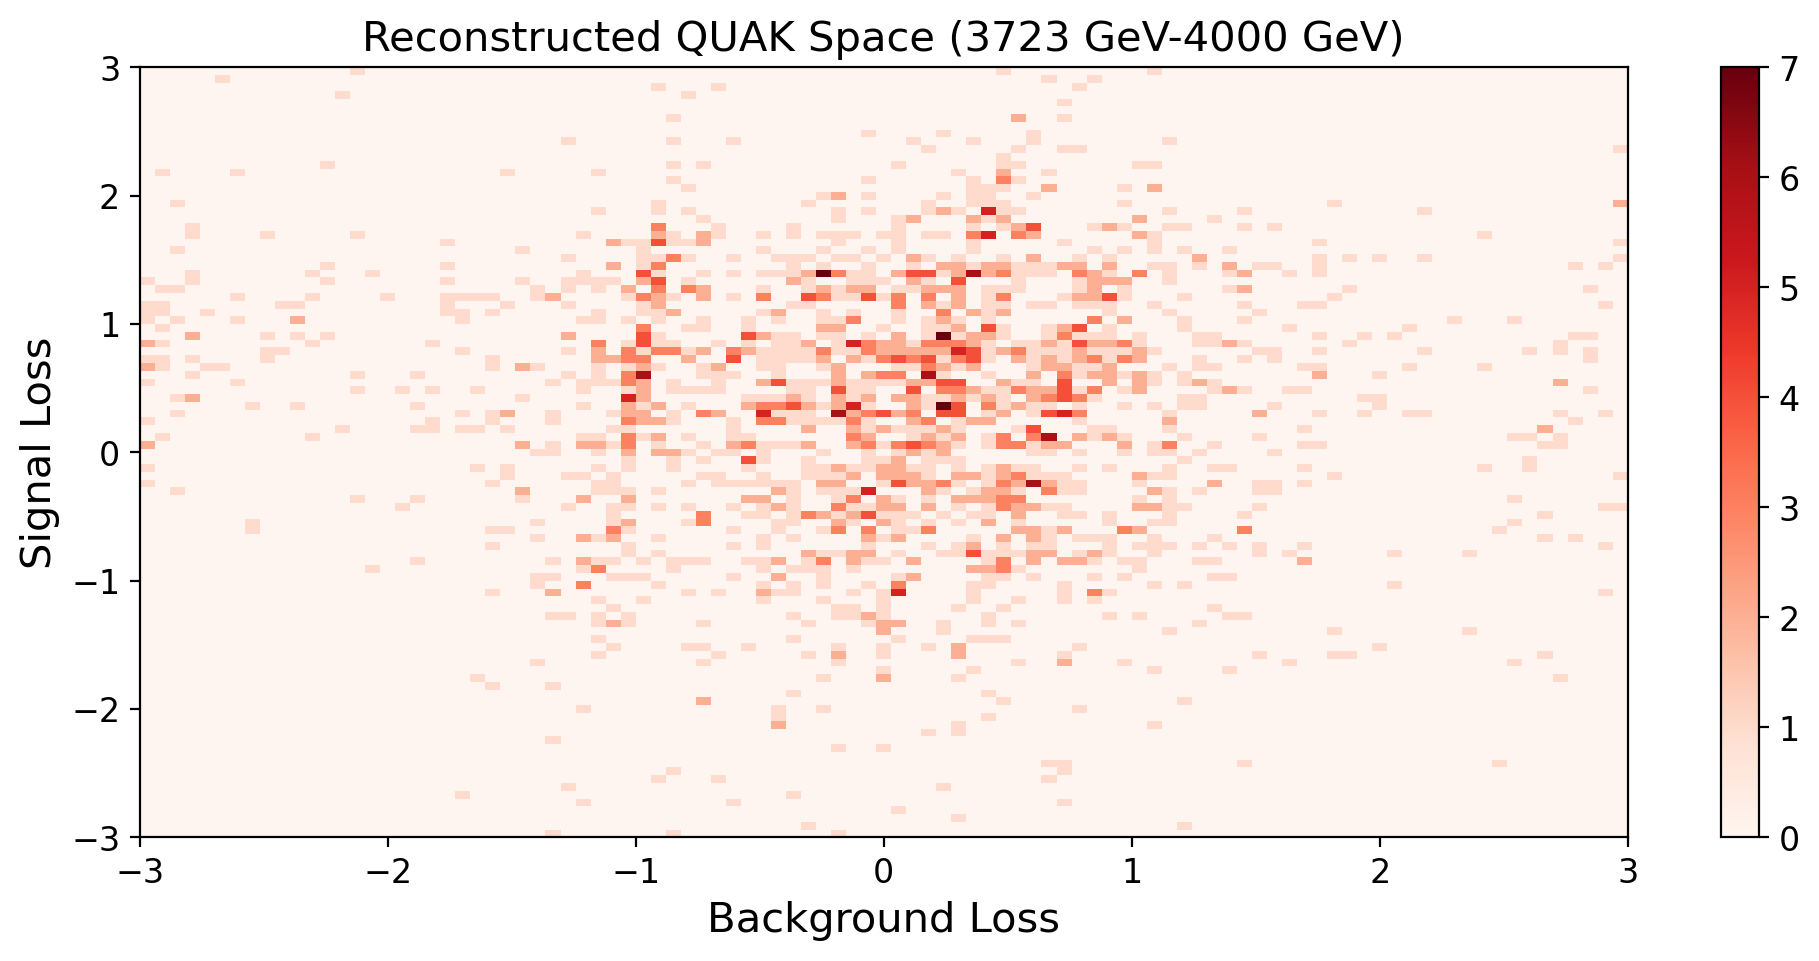

In [27]:
plt.close('all')
true_images = []
reconstructed_images = []
def loss_mass_cut(loss1,loss2,lower_bound,upper_bound, mass = train_mass_tmp):
    loss1 = ak.from_numpy(loss1)
    loss2 = ak.from_numpy(loss2)
    #mass = ak.from_numpy(mass)
    mass_cut = np.logical_and(mass>lower_bound,mass<=upper_bound)
    loss1 = loss1[mass_cut]
    loss2 = loss2[mass_cut]
    loss1 = np.array(loss1)
    loss2 = np.array(loss2)
    return loss1, loss2    
#Quak Space
mass_bins = np.linspace(1500,4000,10)
#QUAK bkg and sig mean and std
Qbkg_mean = []
Qbkg_std = []
Qsig_mean = []
Qsig_std = []
#Reconstructed bkg and sig mean and std
Rbkg_mean = []
Rbkg_std = []
Rsig_mean = []
Rsig_std = []

for i in range(1, len(mass_bins)):
    low_mass = mass_bins[i-1]+1 
    high_mass = mass_bins[i]
    #Plot QUAK and get mean/std for loss 1 and 2
    loss1_cut,loss2_cut = loss_mass_cut(train_loss1,train_loss2,low_mass,high_mass,train_mass_copy)
    plot_quak(loss2_cut,loss1_cut,xlim=[-3,3],ylim=[-3,3],ylabel='Signal Loss',xlabel='Background Loss',title="True QUAK Space ({:.0f} GeV-{:.0f} GeV)".format(low_mass,high_mass),images =true_images)
    tmp = [loss2_cut.mean(),loss2_cut.std(),loss1_cut.mean(),loss1_cut.std()]
    Qbkg_mean.append(tmp[0])
    Qbkg_std.append(tmp[1])
    Qsig_mean.append(tmp[2])
    Qsig_std.append(tmp[3])
    

    #Plot NF Reconstruction and get mean/std for loss 1 and 2
    tmp = reconstruct_mass_range(flow, train_mass_tmp,val_mass,lower_bound = low_mass, upper_bound = high_mass,title='Reconstructed QUAK Space ({:.0f} GeV-{:.0f} GeV)'.format(low_mass,high_mass),images =reconstructed_images)
    Rbkg_mean.append(tmp[0])
    Rbkg_std.append(tmp[1])
    Rsig_mean.append(tmp[2])
    Rsig_std.append(tmp[3])

mass_bins = 0.5*(mass_bins[1:] + mass_bins[:-1])

#save GIFs
from IPython.display import Image
imageio.mimsave('/home/derickfm/true_space.gif', true_images, duration=1)
Image(open('/home/derickfm/true_space.gif','rb').read())
imageio.mimsave('/home/derickfm/reco_space.gif', reconstructed_images, duration=1)
Image(open('/home/derickfm/reco_space.gif','rb').read())

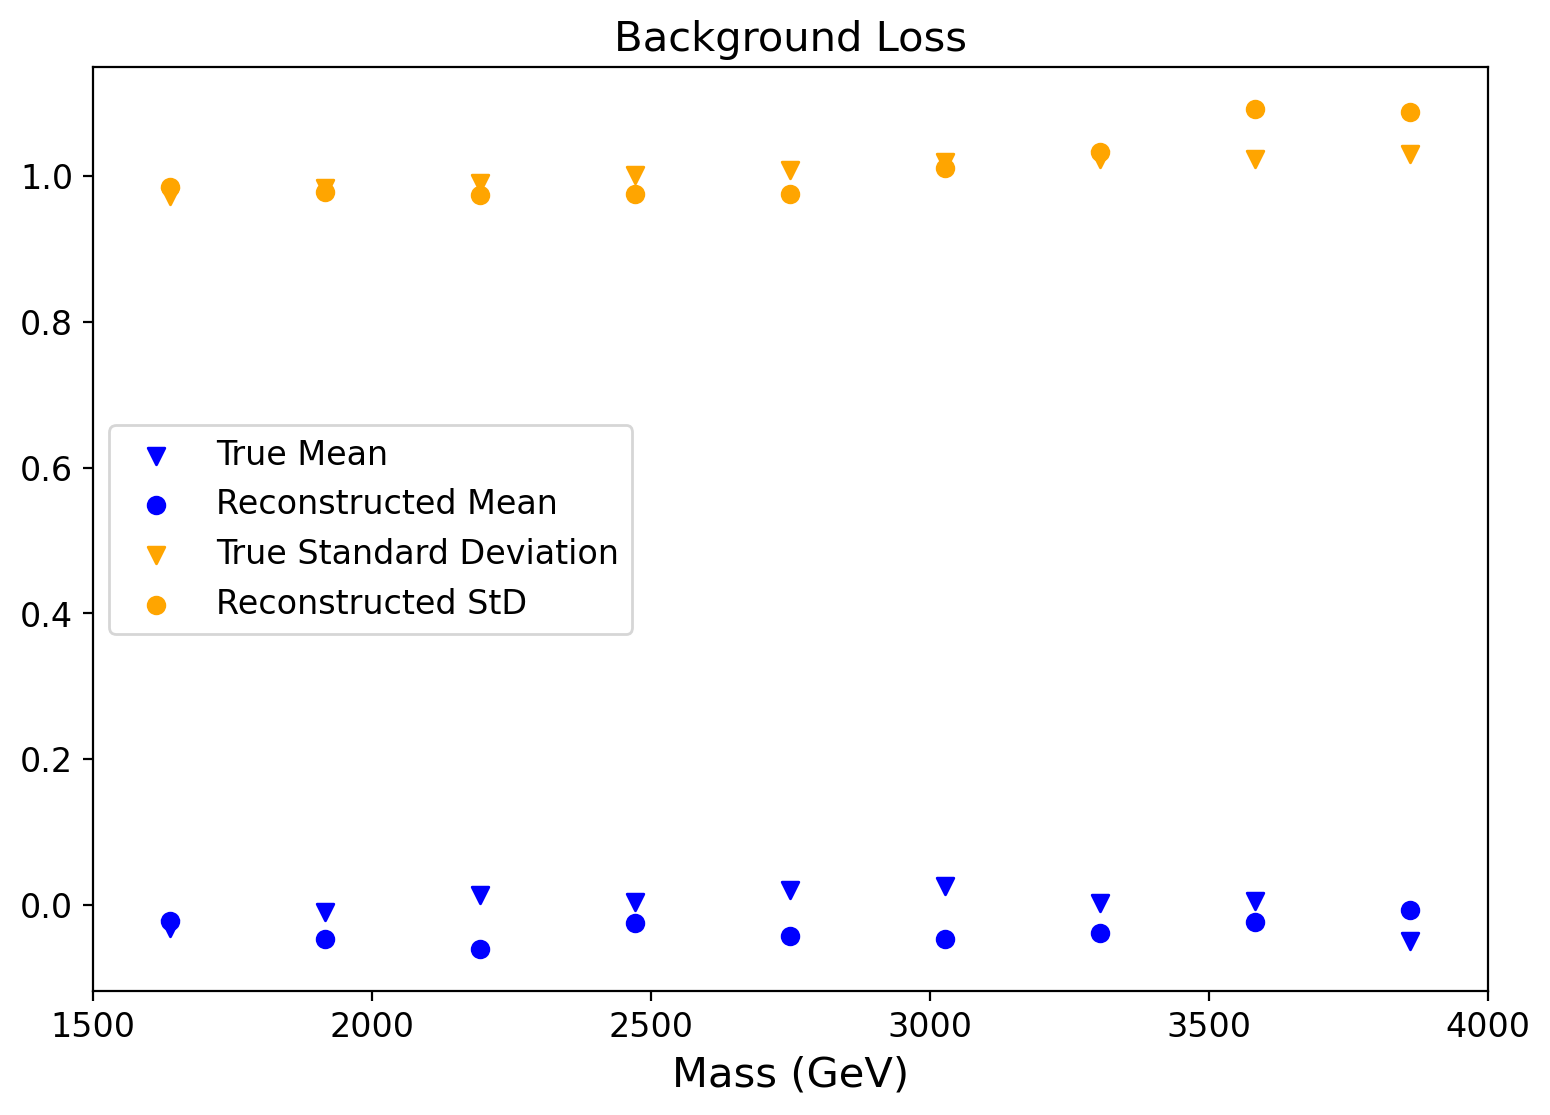

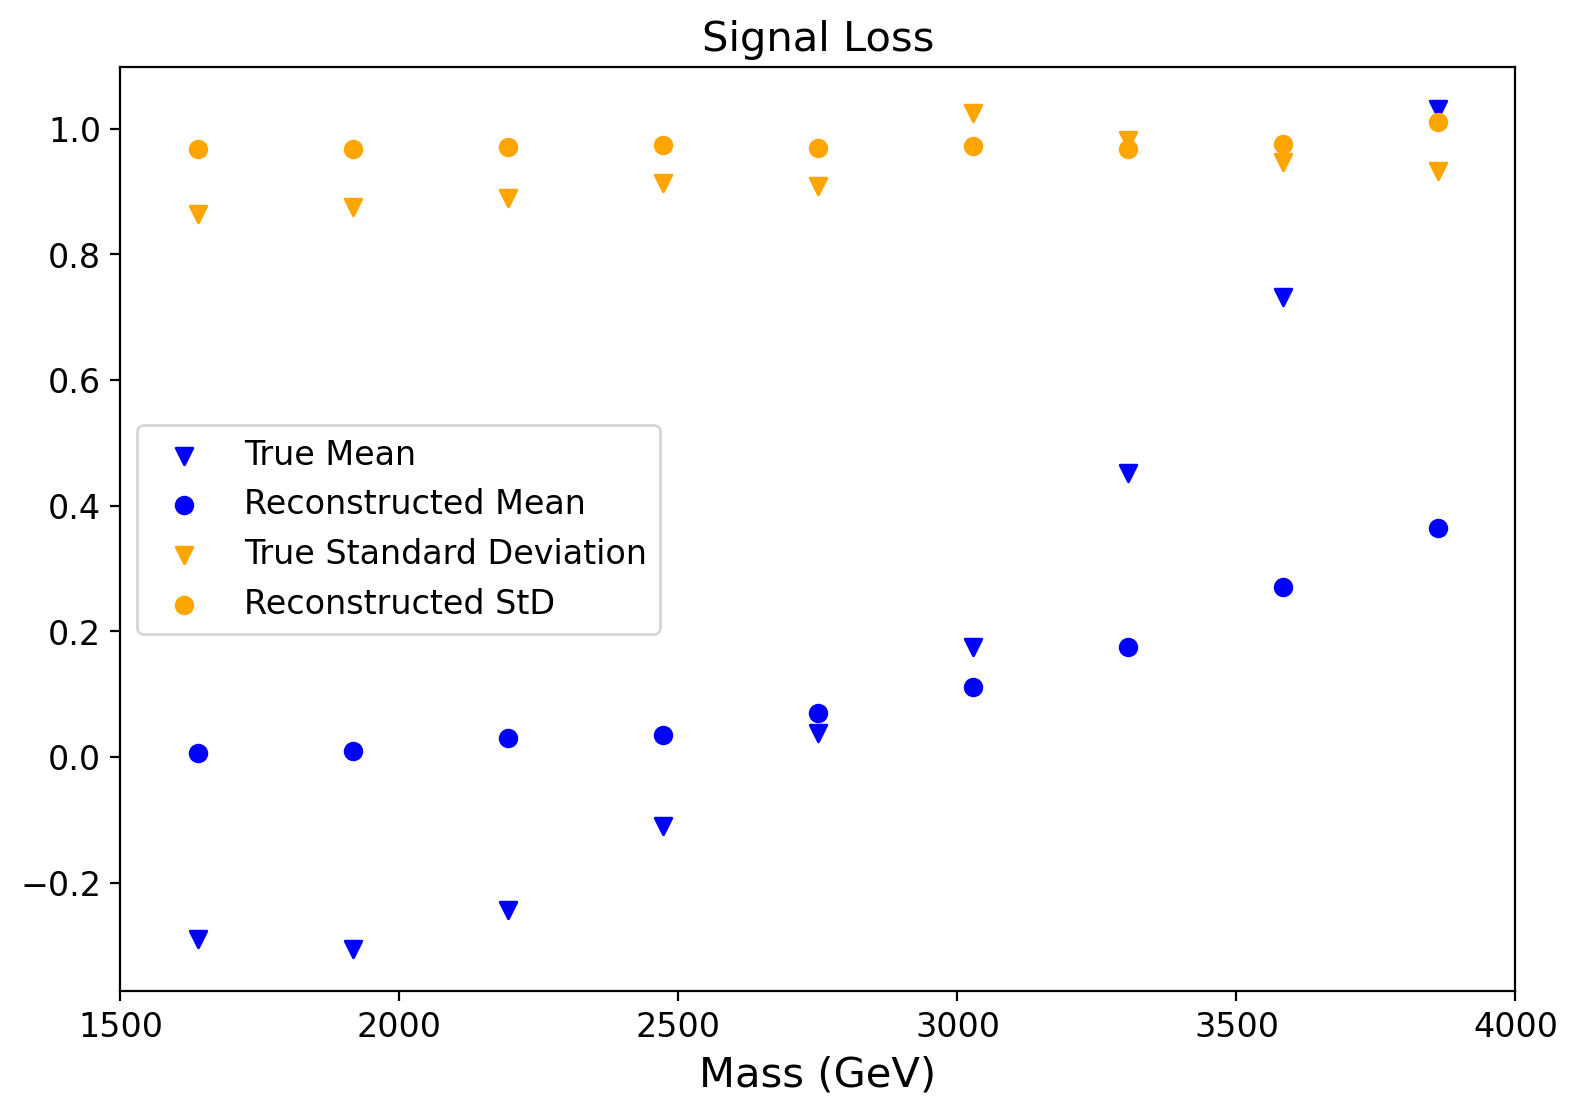

In [28]:

plt.scatter(mass_bins,Qbkg_mean, color = 'blue', marker='v')
plt.scatter(mass_bins,Rbkg_mean,color = 'blue')
plt.scatter(mass_bins,Qbkg_std,color = 'orange', marker='v')
plt.scatter(mass_bins,Rbkg_std,color = 'orange')

plt.title('Background Loss')
plt.xlabel('Mass (GeV)')
plt.legend(['True Mean','Reconstructed Mean','True Standard Deviation','Reconstructed StD'],loc='center left')
plt.xlim([1500,4000])
plt.show()

plt.scatter(mass_bins,Qsig_mean,color = 'blue', marker='v')
plt.scatter(mass_bins,Rsig_mean,color = 'blue')
plt.scatter(mass_bins,Qsig_std,color = 'orange', marker='v')
plt.scatter(mass_bins,Rsig_std,color = 'orange')
plt.title('Signal Loss')
plt.xlabel('Mass (GeV)')
plt.legend(['True Mean','Reconstructed Mean','True Standard Deviation','Reconstructed StD'],loc='center left')
plt.xlim([1500,4000])
plt.show()